In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
import optuna
import japanize_matplotlib
from tqdm import tqdm

In [2]:
# 使用するデータ
suumo = pd.read_csv('./data/csv/SuumoTokyoShaped20221026.csv')

In [15]:
# 変数全部
feature_name = [
    'カテゴリ',
    '建物名',  # いらない
    '経度',  # いる？
    '緯度',  # いる？
    '都道府県',  # いらない
    '市区町村',
    '市区町村以下',  # いらない
    '皇居からの距離',
    '経度(区)',  # いらない
    '緯度(区)',  # いらない
    '路線',
    '駅',
    '経度(駅)',  # いらない
    '緯度(駅)',  # いらない
    '歩',
    'バス',
    '車',
    '最寄駅からの距離',
    '築年数',
    '地上',
    '地下',
    '階数',
    '階',
    '賃料',
    '管理費',  # いる？
    '敷金',  # いる？
    '礼金',  # いる？
    '間取り',
    '部屋数', 
    '間取り_S', 
    '間取り_L', 
    '間取り_D', 
    '間取り_K',
    '専有面積',
    'url',  # いらない
]

In [16]:
# 変数（絶対使わないであろう変数を削除）
feature_name = [
    'カテゴリ',
    '経度',  # いる？
    '緯度',  # いる？
    '市区町村',
    '皇居からの距離',
    '路線',
    '駅',
    '歩',
    'バス',
    '車',
    '最寄駅からの距離',
    '築年数',
    '地上',
    '地下',
    '階数',
    '階',
    '賃料',
    '管理費',  # いる？
    '敷金',  # いる？
    '礼金',  # いる？
    '間取り',
    '部屋数', 
    '間取り_S', 
    '間取り_L', 
    '間取り_D', 
    '間取り_K',
    '専有面積',
]

In [17]:
# 変数（だいたい使うであろう皆さん）
feature_name = [
    'カテゴリ',
    '市区町村',
    '皇居からの距離',
    '路線',
    '駅',
    '歩',
    'バス',
    '車',
    '最寄駅からの距離',
    '築年数',
    '地上',
    '地下',
    '階数',
    '階',
    '賃料',
    '間取り',
    '部屋数', 
    '間取り_S', 
    '間取り_L', 
    '間取り_D', 
    '間取り_K',
    '専有面積',
]

# とりあえず何も考えずLightGBM

結論：線形回帰よか成績が良い。たとえ未調整でも。

In [868]:
# 必要ならデータ加工(未知データに対して実行できないものはやらない)
# シャッフルしてtrainとtestに分ける
# 調整が必要ならtrainをさらにtrainとvalidに分ける
# 必要ならデータ加工
# モデル構築
# モデル学習
# 学習を評価

In [869]:
# 準備フェイズ

# 事前のデータ加工なし
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
    '歩',
    'バス',
    '車',
    '最寄駅からの距離',
    '築年数',
    '地上',
    '地下',
    '階数',
    '階',
    '部屋数', 
    '専有面積',
]
category_features = [
    'カテゴリ',
    '市区町村',
    '路線',
    '駅',
    '間取り',
]
is_features = [
    '間取り_S', 
    '間取り_L', 
    '間取り_D', 
    '間取り_K',
]
target_feature = '賃料'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [870]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]


# 学習用とテスト用に分割
train_test = 0.1
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

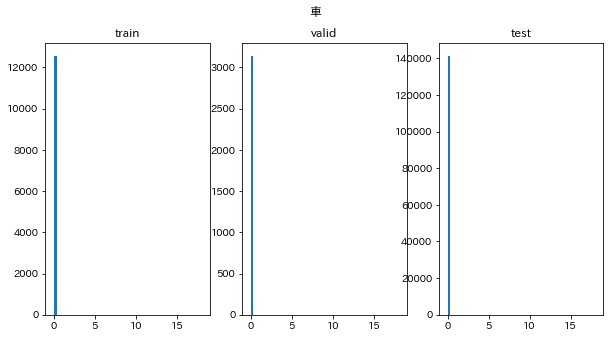

In [871]:
# きれいに分かれているかチェックシステム
# 量的変数の場合

i = 3
max_ = X.loc[:,quantity_features[i]].max()+1
min_ = X.loc[:,quantity_features[i]].min()-1

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.hist(X_train.loc[:,quantity_features[i]], bins=50)
ax1.title.set_text('train')
ax1.set_xlim(min_,max_)
ax2.hist(X_valid.loc[:,quantity_features[i]], bins=50)
ax2.title.set_text('valid')
ax2.set_xlim(min_,max_)
ax3.hist(X_test.loc[:,quantity_features[i]],bins=50)
ax3.title.set_text('test')
ax3.set_xlim(min_,max_)

fig.suptitle(quantity_features[i])
plt.show()

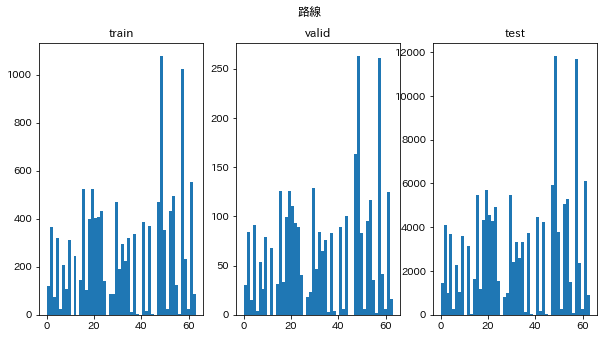

In [872]:
# きれいに分かれているかチェックシステム
# 質的変数の場合

i = 2

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.hist(X_train.loc[:,category_features[i]], bins=50)
ax1.title.set_text('train')
ax2.hist(X_valid.loc[:,category_features[i]], bins=50)
ax2.title.set_text('valid')
ax3.hist(X_test.loc[:,category_features[i]],bins=50)
ax3.title.set_text('test')

fig.suptitle(category_features[i])
plt.show()

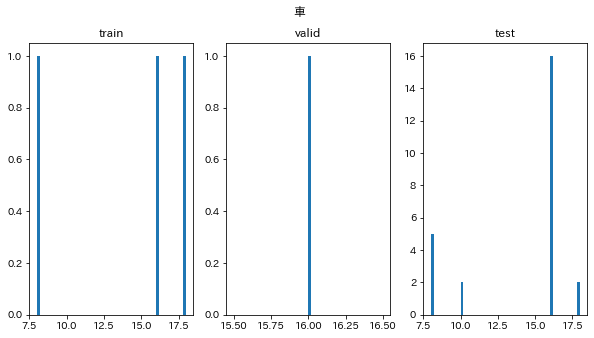

In [873]:
# きれいに分かれているかチェックシステム
# 条件を付けたい場合

i = 3

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

condition1 = X_train.loc[:,features[i]] > 0
condition2 = X_valid.loc[:,features[i]] > 0
condition3 = X_test.loc[:,features[i]] > 0

ax1.hist(X_train.loc[condition1,features[i]], bins=50)
ax1.title.set_text('train')
ax2.hist(X_valid.loc[condition2,features[i]], bins=50)
ax2.title.set_text('valid')
ax3.hist(X_test.loc[condition3,features[i]],bins=50)
ax3.title.set_text('test')

fig.suptitle(features[i])
plt.show()

In [875]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    random_state = 0,
    importance_type = 'gain'
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 36.1407
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 30.4276
[3]	valid_0's l2: 25.7586
[4]	valid_0's l2: 22.1078
[5]	valid_0's l2: 19.0097
[6]	valid_0's l2: 16.467
[7]	valid_0's l2: 14.4764
[8]	valid_0's l2: 12.6896
[9]	valid_0's l2: 11.3433
[10]	valid_0's l2: 10.4176
[11]	valid_0's l2: 9.71753
[12]	valid_0's l2: 9.09653
[13]	valid_0's l2: 8.65601
[14]	valid_0's l2: 8.31693
[15]	valid_0's l2: 7.9772
[16]	valid_0's l2: 7.57179
[17]	valid_0's l2: 7.29651
[18]	valid_0's l2: 7.07377
[19]	valid_0's l2: 6.74799
[20]	valid_0's l2: 6.74399
[21]	valid_0's l2: 6.5101
[22]	valid_0's l2: 6.57456
[23]	valid_0's l2: 6.38822
[24]	valid_0's l2: 6.45245
[25]	valid_0's l2: 6.54624
[26]	valid_0's l2: 6.4252
[27]	valid_0's l2: 6.51121
[28]	valid_0's l2: 6.37994
[29]	valid_0's l2: 6.47256
[30]	valid_0's l2: 6.553
[31]	valid_0's l2: 6.4395
[32]	valid_0's l2: 6.51767
[33]	valid_0's l2: 6.61308
[34]	valid_0's l2: 6.53389
[35]	valid_0's l2: 6.61244
[36]	valid

LGBMRegressor(importance_type='gain', random_state=0)

In [876]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [877]:
# それぞれのr2スコアを算出
print('train:',r2_score(y_train,y_train_pred))
print('valid:',r2_score(y_valid,y_valid_pred))
print('test:',r2_score(y_test,y_test_pred))

train: 0.8911060564468705
valid: 0.8539295917501843
test: 0.7996079443296172


In [878]:
# それぞれのMSEを算出
print('train:',mean_squared_error(y_train,y_train_pred))
print('valid:',mean_squared_error(y_valid,y_valid_pred))
print('test:',mean_squared_error(y_test,y_test_pred))

train: 6.88288720341723
valid: 6.379944333746206
test: 13.604965734266093


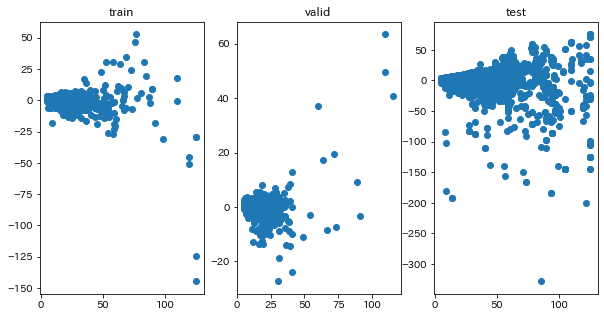

In [879]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, (y_train_pred - y_train))
ax1.title.set_text('train')
ax2.scatter(y_valid_pred, (y_valid_pred - y_valid))
ax2.title.set_text('valid')
ax3.scatter(y_test_pred, (y_test_pred - y_test))
ax3.title.set_text('test')

plt.show()

In [240]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[features, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances

,feature,importance
0,皇居からの距離,1.017353e+05
1,歩,2.529050e+03
2,バス,0.000000e+00
3,車,0.000000e+00
4,最寄駅からの距離,5.867478e+03
5,築年数,3.011440e+05
6,地上,9.082908e+04
7,地下,1.919153e+03
8,階数,3.786050e+04
9,階,2.310983e+04


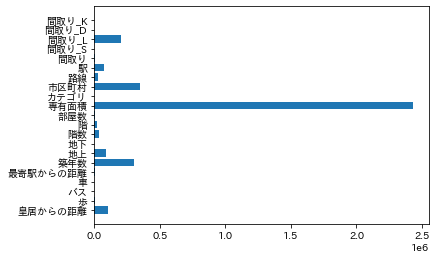

In [243]:
# 変数重要度
plt.barh(table_importances['feature'],table_importances['importance'])
plt.show()

# 賃料を対数変換

結論：結構改善されましたよ

In [880]:
# 必要ならデータ加工(未知データに対して実行できないものはやらない)
# シャッフルしてtrainとtestに分ける
# 調整が必要ならtrainをさらにtrainとvalidに分ける
# 必要ならデータ加工
# モデル構築
# モデル学習
# 学習を評価

In [881]:
# 準備フェイズ

# 事前のデータ加工なし
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
    '歩',
    'バス',
    '車',
    '最寄駅からの距離',
    '築年数',
    '地上',
    '地下',
    '階数',
    '階',
    '部屋数', 
    '専有面積',
]
category_features = [
    'カテゴリ',
    '市区町村',
    '路線',
    '駅',
    '間取り',
]
is_features = [
    '間取り_S', 
    '間取り_L', 
    '間取り_D', 
    '間取り_K',
]
target_feature = '賃料'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [882]:
# 賃料に対数変換を施す
suumo_light['賃料'] = np.log10(suumo_light['賃料'])

In [883]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]

# 学習用とテスト用に分割
train_test = 0.1
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [884]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    random_state = 0,
    importance_type = 'gain'
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0297745
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.025126
[3]	valid_0's l2: 0.0212892
[4]	valid_0's l2: 0.0181767
[5]	valid_0's l2: 0.0156335
[6]	valid_0's l2: 0.0135042
[7]	valid_0's l2: 0.0117504
[8]	valid_0's l2: 0.0102551
[9]	valid_0's l2: 0.00904805
[10]	valid_0's l2: 0.00797265
[11]	valid_0's l2: 0.00709997
[12]	valid_0's l2: 0.00638866
[13]	valid_0's l2: 0.00575848
[14]	valid_0's l2: 0.00525513
[15]	valid_0's l2: 0.00482842
[16]	valid_0's l2: 0.00446007
[17]	valid_0's l2: 0.00415582
[18]	valid_0's l2: 0.00390809
[19]	valid_0's l2: 0.00367751
[20]	valid_0's l2: 0.00348081
[21]	valid_0's l2: 0.00330671
[22]	valid_0's l2: 0.00317172
[23]	valid_0's l2: 0.0030446
[24]	valid_0's l2: 0.00294496
[25]	valid_0's l2: 0.00285048
[26]	valid_0's l2: 0.00276389
[27]	valid_0's l2: 0.00269357
[28]	valid_0's l2: 0.00263328
[29]	valid_0's l2: 0.00257348
[30]	valid_0's l2: 0.00252252
[31]	valid_0's l2: 0.00248729
[32]	valid_0's l2: 0.0024549

LGBMRegressor(importance_type='gain', random_state=0)

In [885]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [886]:
# それぞれのr2スコアを算出
# 対数から元に戻そう
print('train:',r2_score(10**y_train,10**y_train_pred))
print('valid:',r2_score(10**y_valid,10**y_valid_pred))
print('test:',r2_score(10**y_test,10**y_test_pred))

train: 0.9485099466089115
valid: 0.9027719558474806
test: 0.8392475903119673


In [887]:
# それぞれのMSEを算出
# 対数から元に戻そう
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 3.2545449087889837
valid: 4.246647331273374
test: 10.91376111787462


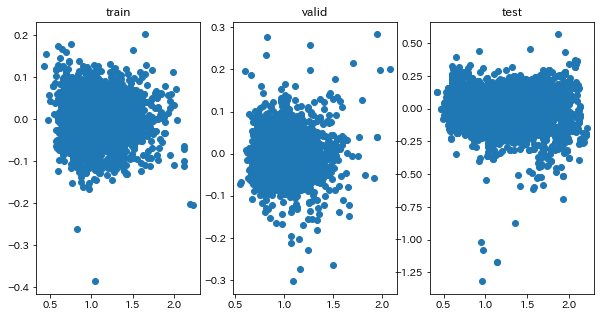

In [888]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, (y_train_pred - y_train))
ax1.title.set_text('train')
ax2.scatter(y_valid_pred, (y_valid_pred - y_valid))
ax2.title.set_text('valid')
ax3.scatter(y_test_pred, (y_test_pred - y_test))
ax3.title.set_text('test')

plt.show()

In [889]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[features, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances

,feature,importance
0,皇居からの距離,40.910795
1,歩,6.981997
2,バス,0.067671
3,車,0.000000
4,最寄駅からの距離,4.382598
5,築年数,151.845537
6,地上,14.693286
7,地下,2.296973
8,階数,46.781564
9,階,9.896321


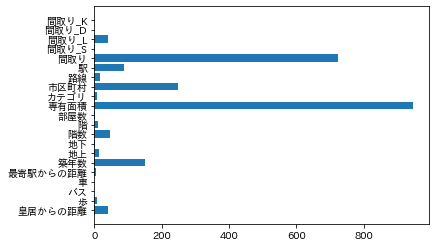

In [891]:
# 変数重要度
# 線形回帰ほどの介護は必要ないらしい
plt.barh(table_importances['feature'],table_importances['importance'])
plt.savefig('./data/image/feature_importance.png')
plt.show()

# 不要な変数を減らしたい　まず1個

結論：間取りくんは実質専有面積だからね。仕方ないね。

In [18]:
# 必要ならデータ加工(未知データに対して実行できないものはやらない)
# シャッフルしてtrainとtestに分ける
# 調整が必要ならtrainをさらにtrainとvalidに分ける
# 必要ならデータ加工
# モデル構築
# モデル学習
# 学習を評価

In [458]:
# 準備フェイズ

# 事前のデータ加工なし
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
    '歩',  
    'バス',  
    '車',  
    '最寄駅からの距離',  
    '築年数',
    '地上',
    '地下', 
    '階数',
    '階',  
    '部屋数',  
    '専有面積',
]
category_features = [
    'カテゴリ',  
    '市区町村',
    '路線',
    '駅',
    '間取り',
]
is_features = [
    '間取り_S',  
    '間取り_L', 
    '間取り_D',  
    '間取り_K',  
]
target_feature = '賃料'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [460]:
# 賃料に対数変換を施す
suumo_light['賃料'] = np.log10(suumo_light['賃料'])

In [470]:
# スコアを貯める器
table_score = []

# 変数を1つ削除してスコアを検証するぞ
for i in tqdm(range(len(features))):
    features_list = features.tolist()
    drop = features_list.pop(i)
    print(drop)
    print(features_list)
    
    # スコアの器
    score = []
    score.append(drop)

    
    # Xとyを定義
    X = suumo_light[features_list]
    y = suumo_light[target_feature]

    # 学習用とテスト用に分割
    train_test = 0.1
    train_valid = 0.8

    X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

    # モデルを構築、学習
    LGBM = lgb.LGBMRegressor(
        random_state = 0,
        importance_type = 'gain'
    )

    verbose_eval = 0
    LGBM.fit(X_train,y_train,
            eval_set=[(X_valid,y_valid)],
            eval_metric = 'mse',
            callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                        lgb.log_evaluation(verbose_eval)])

    # それぞれの予測結果を収納
    y_train_pred = LGBM.predict(X_train)
    y_valid_pred = LGBM.predict(X_valid)
    y_test_pred = LGBM.predict(X_test)

    # それぞれのr2スコアを算出
    # 対数から元に戻そう
    score.append(r2_score(10**y_train,10**y_train_pred))
    score.append(r2_score(10**y_valid,10**y_valid_pred))
    score.append(r2_score(10**y_test,10**y_test_pred))

    # それぞれのMSEを算出
    # 対数から元に戻そう
    score.append(mean_squared_error(10**y_train,10**y_train_pred))
    score.append(mean_squared_error(10**y_valid,10**y_valid_pred))
    score.append(mean_squared_error(10**y_test,10**y_test_pred))
    
    # スコアを器に入れる
    table_score.append(score)

  0%|          | 0/21 [00:00<?, ?it/s]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


皇居からの距離
['歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0020877


  5%|▍         | 1/21 [00:01<00:27,  1.38s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


歩
['皇居からの距離', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00206878


 10%|▉         | 2/21 [00:02<00:24,  1.31s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


バス
['皇居からの距離', '歩', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00201891


 14%|█▍        | 3/21 [00:03<00:22,  1.26s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


車
['皇居からの距離', '歩', 'バス', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0020161


 19%|█▉        | 4/21 [00:05<00:20,  1.23s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


最寄駅からの距離
['皇居からの距離', '歩', 'バス', '車', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00200048


 24%|██▍       | 5/21 [00:06<00:20,  1.28s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


築年数
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00373114


 29%|██▊       | 6/21 [00:07<00:19,  1.28s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


地上
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00202806


 33%|███▎      | 7/21 [00:09<00:18,  1.35s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


地下
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00199176


 38%|███▊      | 8/21 [00:10<00:17,  1.38s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


階数
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00204976


 43%|████▎     | 9/21 [00:12<00:17,  1.42s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


階
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.00203795


 48%|████▊     | 10/21 [00:13<00:15,  1.41s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


部屋数
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00203478


 52%|█████▏    | 11/21 [00:14<00:14,  1.42s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


専有面積
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', 'カテゴリ', '市区町村', '路線', '駅', '間取り', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.00451636


 57%|█████▋    | 12/21 [00:16<00:12,  1.43s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


カテゴリ
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', '市区町村', '路線', '駅', '間取り', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00202727


 62%|██████▏   | 13/21 [00:17<00:11,  1.39s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


市区町村
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '路線', '駅', '間取り', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00208244


 67%|██████▋   | 14/21 [00:19<00:09,  1.39s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


路線
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '駅', '間取り', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.00203882


 71%|███████▏  | 15/21 [00:20<00:08,  1.39s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


駅
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '間取り', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00201737


 76%|███████▌  | 16/21 [00:21<00:06,  1.31s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


間取り
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.00199552


 81%|████████  | 17/21 [00:22<00:05,  1.28s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


間取り_S
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.00201805


 86%|████████▌ | 18/21 [00:24<00:03,  1.27s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


間取り_L
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り', '間取り_S', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.00204405


 90%|█████████ | 19/21 [00:25<00:02,  1.31s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


間取り_D
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り', '間取り_S', '間取り_L', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0020245


 95%|█████████▌| 20/21 [00:26<00:01,  1.34s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


間取り_K
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り', '間取り_S', '間取り_L', '間取り_D']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00206237


100%|██████████| 21/21 [00:28<00:00,  1.34s/it]


In [478]:
# 変数を1つ減らしたスコアのテーブルを作成
scores = pd.DataFrame(table_score,columns=['feature','r2_train','r2_valid',"r2_test",'mse_train','mse_valid','mse_test'])
scores[['feature','r2_test']].sort_values('r2_test',ascending=False)

,feature,r2_test
16,間取り,0.845062
0,皇居からの距離,0.842724
4,最寄駅からの距離,0.842035
10,部屋数,0.841024
9,階,0.840941
6,地上,0.840374
15,駅,0.840001
3,車,0.839248
20,間取り_K,0.839074
14,路線,0.838465


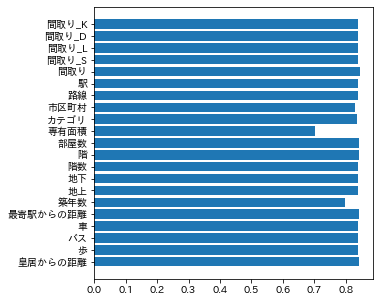

In [475]:
# 全部採用　test: 0.8392475903119673
plt.figure(figsize=(5,5))
plt.barh(scores['feature'],scores['r2_test'])
plt.show()

In [479]:
# 準備フェイズ
# 間取りをなかったことにする

# 事前のデータ加工なし
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
    '歩',
    'バス',
    '車',
    '最寄駅からの距離',
    '築年数',
    '地上',
    '地下',
    '階数',
    '階',
    '部屋数', 
    '専有面積',
]
category_features = [
    'カテゴリ',
    '市区町村',
    '路線',
    '駅',
#    '間取り',
]
is_features = [
    '間取り_S', 
    '間取り_L', 
    '間取り_D', 
    '間取り_K',
]
target_feature = '賃料'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [480]:
# 賃料に対数変換を施す
suumo_light['賃料'] = np.log10(suumo_light['賃料'])

In [481]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]

# 学習用とテスト用に分割
train_test = 0.1
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [486]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    random_state = 0,
    importance_type = 'gain'
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0297711
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0250712
[3]	valid_0's l2: 0.0213529
[4]	valid_0's l2: 0.0182479
[5]	valid_0's l2: 0.0156702
[6]	valid_0's l2: 0.0134941
[7]	valid_0's l2: 0.0116886
[8]	valid_0's l2: 0.0102455
[9]	valid_0's l2: 0.00900646
[10]	valid_0's l2: 0.00795458
[11]	valid_0's l2: 0.00708639
[12]	valid_0's l2: 0.00633001
[13]	valid_0's l2: 0.00571938
[14]	valid_0's l2: 0.00521149
[15]	valid_0's l2: 0.00477946
[16]	valid_0's l2: 0.00443199
[17]	valid_0's l2: 0.00411935
[18]	valid_0's l2: 0.00385735
[19]	valid_0's l2: 0.00365356
[20]	valid_0's l2: 0.0034577
[21]	valid_0's l2: 0.00328958
[22]	valid_0's l2: 0.00315187
[23]	valid_0's l2: 0.0030292
[24]	valid_0's l2: 0.00292685
[25]	valid_0's l2: 0.00283577
[26]	valid_0's l2: 0.00276224
[27]	valid_0's l2: 0.00269334
[28]	valid_0's l2: 0.00262841
[29]	valid_0's l2: 0.00257659
[30]	valid_0's l2: 0.00252649
[31]	valid_0's l2: 0.00247801
[32]	valid_0's l2: 0.0024436

LGBMRegressor(importance_type='gain', random_state=0)

In [487]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [488]:
# それぞれのr2スコアを算出
# 対数から元に戻そう
print('train:',r2_score(10**y_train,10**y_train_pred))
print('valid:',r2_score(10**y_valid,10**y_valid_pred))
print('test:',r2_score(10**y_test,10**y_test_pred))

train: 0.9505062651898922
valid: 0.9020707397097577
test: 0.8450619199641548


In [489]:
# それぞれのMSEを算出
# 対数から元に戻そう
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 3.128363092182515
valid: 4.277274478675779
test: 10.519016149462031


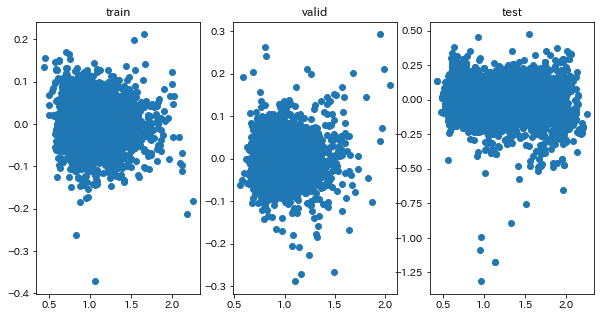

In [490]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, (y_train_pred - y_train))
ax1.title.set_text('train')
ax2.scatter(y_valid_pred, (y_valid_pred - y_valid))
ax2.title.set_text('valid')
ax3.scatter(y_test_pred, (y_test_pred - y_test))
ax3.title.set_text('test')

plt.show()

In [491]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[features, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances

,feature,importance
0,皇居からの距離,39.731142
1,歩,7.231472
2,バス,0.069280
3,車,0.000000
4,最寄駅からの距離,4.348808
5,築年数,149.318566
6,地上,16.017700
7,地下,1.885394
8,階数,44.999900
9,階,9.746645


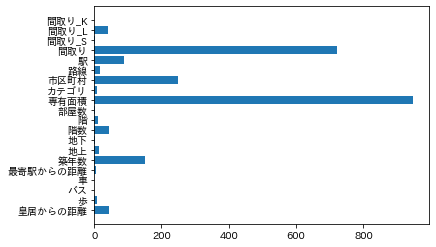

In [368]:
# 変数重要度
# 線形回帰ほどの介護は必要ないらしい
plt.barh(table_importances['feature'],table_importances['importance'])
plt.show()

# 不要な変数を減らしたい　2個目

結論：階変数が不要。階数と似たようなもんだししゃーない

In [18]:
# 必要ならデータ加工(未知データに対して実行できないものはやらない)
# シャッフルしてtrainとtestに分ける
# 調整が必要ならtrainをさらにtrainとvalidに分ける
# 必要ならデータ加工
# モデル構築
# モデル学習
# 学習を評価

In [492]:
# 準備フェイズ

# 事前のデータ加工なし
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
    '歩',  
    'バス',  
    '車',  
    '最寄駅からの距離',  
    '築年数',
    '地上',
    '地下', 
    '階数',
    '階',  
    '部屋数',  
    '専有面積',
]
category_features = [
    'カテゴリ',  
    '市区町村',
    '路線',
    '駅',
#    '間取り',
]
is_features = [
    '間取り_S',  
    '間取り_L', 
    '間取り_D',  
    '間取り_K',  
]
target_feature = '賃料'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [493]:
# 賃料に対数変換を施す
suumo_light['賃料'] = np.log10(suumo_light['賃料'])

In [495]:
# スコアを貯める器
table_score = []

# 変数を1つ削除してスコアを検証するぞ
for i in tqdm(range(len(features))):
    features_list = features.tolist()
    drop = features_list.pop(i)
    print(drop)
    print(features_list)
    
    # スコアの器
    score = []
    score.append(drop)

    
    # Xとyを定義
    X = suumo_light[features_list]
    y = suumo_light[target_feature]

    # 学習用とテスト用に分割
    train_test = 0.1
    train_valid = 0.8

    X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

    # モデルを構築、学習
    LGBM = lgb.LGBMRegressor(
        random_state = 0,
        importance_type = 'gain'
    )

    verbose_eval = 0
    LGBM.fit(X_train,y_train,
            eval_set=[(X_valid,y_valid)],
            eval_metric = 'mse',
            callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                        lgb.log_evaluation(verbose_eval)])

    # それぞれの予測結果を収納
    y_train_pred = LGBM.predict(X_train)
    y_valid_pred = LGBM.predict(X_valid)
    y_test_pred = LGBM.predict(X_test)

    # それぞれのr2スコアを算出
    # 対数から元に戻そう
    score.append(r2_score(10**y_train,10**y_train_pred))
    score.append(r2_score(10**y_valid,10**y_valid_pred))
    score.append(r2_score(10**y_test,10**y_test_pred))

    # それぞれのMSEを算出
    # 対数から元に戻そう
    score.append(mean_squared_error(10**y_train,10**y_train_pred))
    score.append(mean_squared_error(10**y_valid,10**y_valid_pred))
    score.append(mean_squared_error(10**y_test,10**y_test_pred))
    
    # スコアを器に入れる
    table_score.append(score)

  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


皇居からの距離
['歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.00204816


  5%|▌         | 1/20 [00:01<00:25,  1.32s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


歩
['皇居からの距離', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's l2: 0.00205766


 10%|█         | 2/20 [00:02<00:22,  1.25s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


バス
['皇居からの距離', '歩', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00198303


 15%|█▌        | 3/20 [00:03<00:20,  1.23s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


車
['皇居からの距離', '歩', 'バス', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.00199552


 20%|██        | 4/20 [00:05<00:19,  1.25s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


最寄駅からの距離
['皇居からの距離', '歩', 'バス', '車', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00201525


 25%|██▌       | 5/20 [00:06<00:19,  1.30s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


築年数
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0037076


 30%|███       | 6/20 [00:07<00:18,  1.29s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


地上
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.00199657


 35%|███▌      | 7/20 [00:09<00:17,  1.31s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


地下
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00200231


 40%|████      | 8/20 [00:10<00:15,  1.30s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


階数
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00198203


 45%|████▌     | 9/20 [00:11<00:14,  1.30s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


階
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.00204449


 50%|█████     | 10/20 [00:12<00:12,  1.28s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


部屋数
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0020156


 55%|█████▌    | 11/20 [00:14<00:11,  1.29s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


専有面積
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00458172


 60%|██████    | 12/20 [00:15<00:10,  1.31s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


カテゴリ
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00202296


 65%|██████▌   | 13/20 [00:16<00:09,  1.31s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


市区町村
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.00204562


 70%|███████   | 14/20 [00:18<00:08,  1.34s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


路線
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00201145


 75%|███████▌  | 15/20 [00:19<00:06,  1.37s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


駅
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00203338


 80%|████████  | 16/20 [00:20<00:05,  1.30s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


間取り_S
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0019837


 85%|████████▌ | 17/20 [00:22<00:03,  1.29s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


間取り_L
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.0020033


 90%|█████████ | 18/20 [00:23<00:02,  1.29s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


間取り_D
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00198607


 95%|█████████▌| 19/20 [00:24<00:01,  1.27s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


間取り_K
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '階', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00199411


100%|██████████| 20/20 [00:25<00:00,  1.30s/it]


In [496]:
# 変数を1つ減らしたスコアのテーブルを作成
scores = pd.DataFrame(table_score,columns=['feature','r2_train','r2_valid',"r2_test",'mse_train','mse_valid','mse_test'])
scores[['feature','r2_test']].sort_values('r2_test',ascending=False)

,feature,r2_test
9,階,0.846953
18,間取り_D,0.846251
16,間取り_S,0.846127
3,車,0.845062
14,路線,0.844829
0,皇居からの距離,0.844763
1,歩,0.844401
2,バス,0.844395
12,カテゴリ,0.844104
6,地上,0.844028


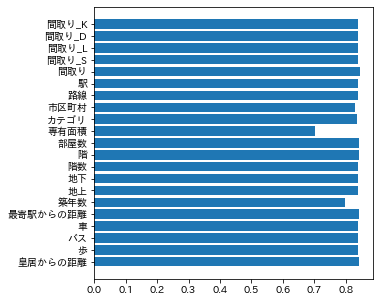

In [475]:
# 1個削除　test: 0.8450619199641548
plt.figure(figsize=(5,5))
plt.barh(scores['feature'],scores['r2_test'])
plt.show()

In [497]:
# 準備フェイズ
# 階をなかったことにする

# 事前のデータ加工なし
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
    '歩',
    'バス',
    '車',
    '最寄駅からの距離',
    '築年数',
    '地上',
    '地下',
    '階数',
#    '階',
    '部屋数', 
    '専有面積',
]
category_features = [
    'カテゴリ',
    '市区町村',
    '路線',
    '駅',
#    '間取り',
]
is_features = [
    '間取り_S', 
    '間取り_L', 
    '間取り_D', 
    '間取り_K',
]
target_feature = '賃料'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [498]:
# 賃料に対数変換を施す
suumo_light['賃料'] = np.log10(suumo_light['賃料'])

In [499]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]

# 学習用とテスト用に分割
train_test = 0.1
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [504]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    random_state = 0,
    importance_type = 'gain'
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0297711
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0250712
[3]	valid_0's l2: 0.0213529
[4]	valid_0's l2: 0.0182479
[5]	valid_0's l2: 0.0156702
[6]	valid_0's l2: 0.0134941
[7]	valid_0's l2: 0.0116886
[8]	valid_0's l2: 0.0102455
[9]	valid_0's l2: 0.00900957
[10]	valid_0's l2: 0.00795719
[11]	valid_0's l2: 0.00708795
[12]	valid_0's l2: 0.00633433
[13]	valid_0's l2: 0.00572037
[14]	valid_0's l2: 0.0052151
[15]	valid_0's l2: 0.00478457
[16]	valid_0's l2: 0.00443703
[17]	valid_0's l2: 0.00412288
[18]	valid_0's l2: 0.00386215
[19]	valid_0's l2: 0.00362627
[20]	valid_0's l2: 0.0034477
[21]	valid_0's l2: 0.00329635
[22]	valid_0's l2: 0.0031656
[23]	valid_0's l2: 0.00304609
[24]	valid_0's l2: 0.00295185
[25]	valid_0's l2: 0.00286022
[26]	valid_0's l2: 0.00277847
[27]	valid_0's l2: 0.00270369
[28]	valid_0's l2: 0.00263715
[29]	valid_0's l2: 0.00258851
[30]	valid_0's l2: 0.00254419
[31]	valid_0's l2: 0.00250678
[32]	valid_0's l2: 0.00246414

LGBMRegressor(importance_type='gain', random_state=0)

In [505]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [506]:
# それぞれのr2スコアを算出
# 対数から元に戻そう
print('train:',r2_score(10**y_train,10**y_train_pred))
print('valid:',r2_score(10**y_valid,10**y_valid_pred))
print('test:',r2_score(10**y_test,10**y_test_pred))

train: 0.9517792193269062
valid: 0.8840169795321785
test: 0.8469527738499714


In [507]:
# それぞれのMSEを算出
# 対数から元に戻そう
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 3.047903156080413
valid: 5.065811912970958
test: 10.390642785363445


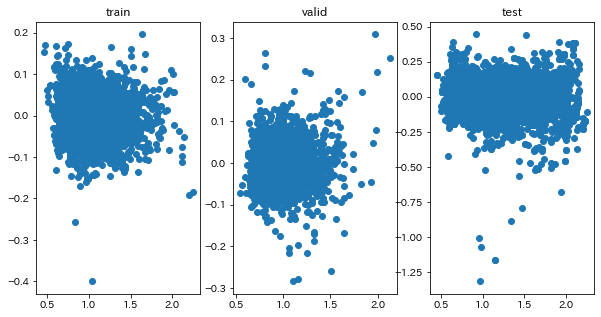

In [508]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, (y_train_pred - y_train))
ax1.title.set_text('train')
ax2.scatter(y_valid_pred, (y_valid_pred - y_valid))
ax2.title.set_text('valid')
ax3.scatter(y_test_pred, (y_test_pred - y_test))
ax3.title.set_text('test')

plt.show()

In [509]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[features, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances

,feature,importance
0,皇居からの距離,41.399644
1,歩,6.929258
2,バス,0.032486
3,車,0.000000
4,最寄駅からの距離,5.057370
5,築年数,149.867876
6,地上,17.890410
7,地下,1.665211
8,階数,44.787965
9,部屋数,2.813527


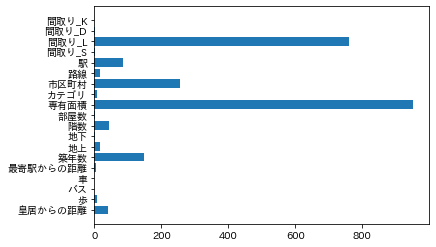

In [510]:
# 変数重要度
# 線形回帰ほどの介護は必要ないらしい
plt.barh(table_importances['feature'],table_importances['importance'])
plt.show()

# 不要な変数を減らしたい　3個目

結論：間取り_Kが不要。1Kとワンルームは大差ないらしい

In [18]:
# 必要ならデータ加工(未知データに対して実行できないものはやらない)
# シャッフルしてtrainとtestに分ける
# 調整が必要ならtrainをさらにtrainとvalidに分ける
# 必要ならデータ加工
# モデル構築
# モデル学習
# 学習を評価

In [511]:
# 準備フェイズ

# 事前のデータ加工なし
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
    '歩',  
    'バス',  
    '車',  
    '最寄駅からの距離',  
    '築年数',
    '地上',
    '地下', 
    '階数',
#    '階',  
    '部屋数',  
    '専有面積',
]
category_features = [
    'カテゴリ',  
    '市区町村',
    '路線',
    '駅',
#    '間取り',
]
is_features = [
    '間取り_S',  
    '間取り_L', 
    '間取り_D',  
    '間取り_K',  
]
target_feature = '賃料'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [512]:
# 賃料に対数変換を施す
suumo_light['賃料'] = np.log10(suumo_light['賃料'])

In [513]:
# スコアを貯める器
table_score = []

# 変数を1つ削除してスコアを検証するぞ
for i in tqdm(range(len(features))):
    features_list = features.tolist()
    drop = features_list.pop(i)
    
    # スコアの器
    score = []
    score.append(drop)

    
    # Xとyを定義
    X = suumo_light[features_list]
    y = suumo_light[target_feature]

    # 学習用とテスト用に分割
    train_test = 0.1
    train_valid = 0.8

    X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

    # モデルを構築、学習
    LGBM = lgb.LGBMRegressor(
        random_state = 0,
        importance_type = 'gain'
    )

    verbose_eval = 0
    LGBM.fit(X_train,y_train,
            eval_set=[(X_valid,y_valid)],
            eval_metric = 'mse',
            callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                        lgb.log_evaluation(verbose_eval)])

    # それぞれの予測結果を収納
    y_train_pred = LGBM.predict(X_train)
    y_valid_pred = LGBM.predict(X_valid)
    y_test_pred = LGBM.predict(X_test)

    # それぞれのr2スコアを算出
    # 対数から元に戻そう
    score.append(r2_score(10**y_train,10**y_train_pred))
    score.append(r2_score(10**y_valid,10**y_valid_pred))
    score.append(r2_score(10**y_test,10**y_test_pred))

    # それぞれのMSEを算出
    # 対数から元に戻そう
    score.append(mean_squared_error(10**y_train,10**y_train_pred))
    score.append(mean_squared_error(10**y_valid,10**y_valid_pred))
    score.append(mean_squared_error(10**y_test,10**y_test_pred))
    
    # スコアを器に入れる
    table_score.append(score)

  0%|          | 0/19 [00:00<?, ?it/s]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


皇居からの距離
['歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00208843


  5%|▌         | 1/19 [00:01<00:26,  1.47s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


歩
['皇居からの距離', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.00209005


 11%|█         | 2/19 [00:02<00:24,  1.46s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


バス
['皇居からの距離', '歩', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0020401


 16%|█▌        | 3/19 [00:04<00:24,  1.54s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


車
['皇居からの距離', '歩', 'バス', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.00204449


 21%|██        | 4/19 [00:05<00:22,  1.47s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


最寄駅からの距離
['皇居からの距離', '歩', 'バス', '車', '築年数', '地上', '地下', '階数', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0020388


 26%|██▋       | 5/19 [00:07<00:20,  1.46s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


築年数
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '地上', '地下', '階数', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00372157


 32%|███▏      | 6/19 [00:08<00:17,  1.36s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


地上
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地下', '階数', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00202762


 37%|███▋      | 7/19 [00:09<00:15,  1.31s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


地下
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '階数', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00202363


 42%|████▏     | 8/19 [00:11<00:14,  1.31s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


階数
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00203006


 47%|████▋     | 9/19 [00:12<00:13,  1.32s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


部屋数
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00207856


 53%|█████▎    | 10/19 [00:13<00:12,  1.34s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


専有面積
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '部屋数', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00457955


 58%|█████▊    | 11/19 [00:14<00:10,  1.27s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


カテゴリ
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '部屋数', '専有面積', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00205402


 63%|██████▎   | 12/19 [00:16<00:08,  1.27s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


市区町村
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '部屋数', '専有面積', 'カテゴリ', '路線', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.00209265


 68%|██████▊   | 13/19 [00:17<00:07,  1.27s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


路線
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '部屋数', '専有面積', 'カテゴリ', '市区町村', '駅', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00203912


 74%|███████▎  | 14/19 [00:18<00:06,  1.30s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


駅
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '間取り_S', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.002078


 79%|███████▉  | 15/19 [00:20<00:05,  1.31s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


間取り_S
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_L', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00203304


 84%|████████▍ | 16/19 [00:21<00:04,  1.38s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


間取り_L
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_D', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00202621


 89%|████████▉ | 17/19 [00:23<00:02,  1.40s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


間取り_D
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_K']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.00204629


 95%|█████████▍| 18/19 [00:24<00:01,  1.39s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


間取り_K
['皇居からの距離', '歩', 'バス', '車', '最寄駅からの距離', '築年数', '地上', '地下', '階数', '部屋数', '専有面積', 'カテゴリ', '市区町村', '路線', '駅', '間取り_S', '間取り_L', '間取り_D']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00204494


100%|██████████| 19/19 [00:25<00:00,  1.36s/it]


In [514]:
# 変数を1つ減らしたスコアのテーブルを作成
scores = pd.DataFrame(table_score,columns=['feature','r2_train','r2_valid',"r2_test",'mse_train','mse_valid','mse_test'])
scores[['feature','r2_test']].sort_values('r2_test',ascending=False)

,feature,r2_test
18,間取り_K,0.848695
2,バス,0.848326
0,皇居からの距離,0.848026
11,カテゴリ,0.847521
3,車,0.846953
9,部屋数,0.845476
4,最寄駅からの距離,0.845468
7,地下,0.845340
1,歩,0.845214
6,地上,0.844922


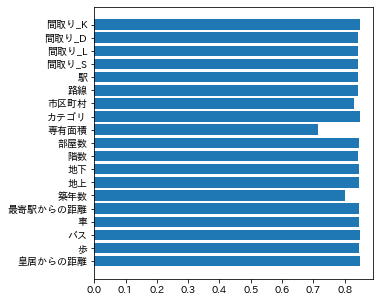

In [515]:
# 2個削除　test: 0.8469527738499714
plt.figure(figsize=(5,5))
plt.barh(scores['feature'],scores['r2_test'])
plt.show()

In [516]:
# 準備フェイズ
# 階をなかったことにする

# 事前のデータ加工なし
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
    '歩',
    'バス',
    '車',
    '最寄駅からの距離',
    '築年数',
    '地上',
    '地下',
    '階数',
#    '階',
    '部屋数', 
    '専有面積',
]
category_features = [
    'カテゴリ',
    '市区町村',
    '路線',
    '駅',
#    '間取り',
]
is_features = [
    '間取り_S', 
    '間取り_L', 
    '間取り_D', 
#    '間取り_K',
]
target_feature = '賃料'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [517]:
# 賃料に対数変換を施す
suumo_light['賃料'] = np.log10(suumo_light['賃料'])

In [518]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]

# 学習用とテスト用に分割
train_test = 0.1
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [523]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    random_state = 0,
    importance_type = 'gain'
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0297711
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0250712
[3]	valid_0's l2: 0.0213529
[4]	valid_0's l2: 0.0182479
[5]	valid_0's l2: 0.0156702
[6]	valid_0's l2: 0.0134941
[7]	valid_0's l2: 0.0116886
[8]	valid_0's l2: 0.0102455
[9]	valid_0's l2: 0.00900957
[10]	valid_0's l2: 0.00795719
[11]	valid_0's l2: 0.00708795
[12]	valid_0's l2: 0.00633433
[13]	valid_0's l2: 0.00572037
[14]	valid_0's l2: 0.0052151
[15]	valid_0's l2: 0.00478457
[16]	valid_0's l2: 0.00443703
[17]	valid_0's l2: 0.00412288
[18]	valid_0's l2: 0.00386215
[19]	valid_0's l2: 0.00362627
[20]	valid_0's l2: 0.0034477
[21]	valid_0's l2: 0.00329635
[22]	valid_0's l2: 0.0031656
[23]	valid_0's l2: 0.00304609
[24]	valid_0's l2: 0.00295185
[25]	valid_0's l2: 0.00286022
[26]	valid_0's l2: 0.00277847
[27]	valid_0's l2: 0.00270369
[28]	valid_0's l2: 0.00263715
[29]	valid_0's l2: 0.00258851
[30]	valid_0's l2: 0.00254419
[31]	valid_0's l2: 0.00250678
[32]	valid_0's l2: 0.00246414

LGBMRegressor(importance_type='gain', random_state=0)

In [524]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [525]:
# それぞれのr2スコアを算出
# 対数から元に戻そう
print('train:',r2_score(10**y_train,10**y_train_pred))
print('valid:',r2_score(10**y_valid,10**y_valid_pred))
print('test:',r2_score(10**y_test,10**y_test_pred))

train: 0.9544207406759597
valid: 0.8837448033748329
test: 0.8486947200144128


In [526]:
# それぞれのMSEを算出
# 対数から元に戻そう
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 2.8809398439097724
valid: 5.077699801514876
test: 10.272379025860202


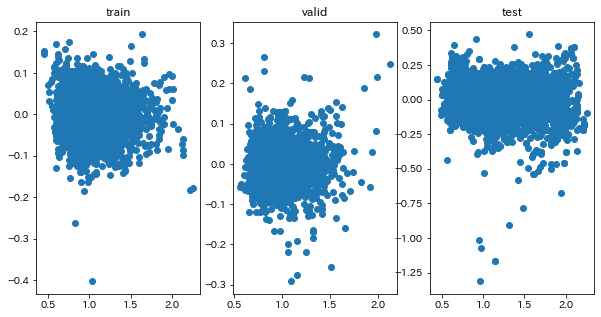

In [527]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, (y_train_pred - y_train))
ax1.title.set_text('train')
ax2.scatter(y_valid_pred, (y_valid_pred - y_valid))
ax2.title.set_text('valid')
ax3.scatter(y_test_pred, (y_test_pred - y_test))
ax3.title.set_text('test')

plt.show()

In [528]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[features, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances

,feature,importance
0,皇居からの距離,41.642421
1,歩,7.161370
2,バス,0.038285
3,車,0.000000
4,最寄駅からの距離,4.996618
5,築年数,149.817615
6,地上,17.867209
7,地下,1.626089
8,階数,45.012226
9,部屋数,2.897143


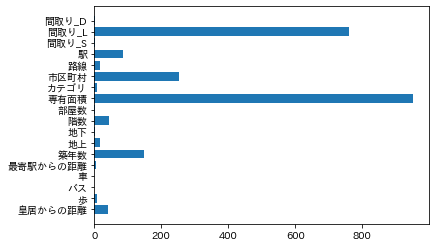

In [529]:
# 変数重要度
# 線形回帰ほどの介護は必要ないらしい
plt.barh(table_importances['feature'],table_importances['importance'])
plt.show()

# 不要な変数を減らしたい　4個目

結論：地上変数が不要。階変数同似た者同士は排斥されるのだ

In [530]:
# 必要ならデータ加工(未知データに対して実行できないものはやらない)
# シャッフルしてtrainとtestに分ける
# 調整が必要ならtrainをさらにtrainとvalidに分ける
# 必要ならデータ加工
# モデル構築
# モデル学習
# 学習を評価

In [531]:
# 準備フェイズ

# 事前のデータ加工なし
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
    '歩',  
    'バス',  
    '車',  
    '最寄駅からの距離',  
    '築年数',
    '地上',
    '地下', 
    '階数',
#    '階',  
    '部屋数',  
    '専有面積',
]
category_features = [
    'カテゴリ',  
    '市区町村',
    '路線',
    '駅',
#    '間取り',
]
is_features = [
    '間取り_S',  
    '間取り_L', 
    '間取り_D',  
#    '間取り_K',  
]
target_feature = '賃料'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [532]:
# 賃料に対数変換を施す
suumo_light['賃料'] = np.log10(suumo_light['賃料'])

In [533]:
# スコアを貯める器
table_score = []

# 変数を1つ削除してスコアを検証するぞ
for i in tqdm(range(len(features))):
    features_list = features.tolist()
    drop = features_list.pop(i)
    
    # スコアの器
    score = []
    score.append(drop)

    
    # Xとyを定義
    X = suumo_light[features_list]
    y = suumo_light[target_feature]

    # 学習用とテスト用に分割
    train_test = 0.1
    train_valid = 0.8

    X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

    # モデルを構築、学習
    LGBM = lgb.LGBMRegressor(
        random_state = 0,
        importance_type = 'gain'
    )

    verbose_eval = 0
    LGBM.fit(X_train,y_train,
            eval_set=[(X_valid,y_valid)],
            eval_metric = 'mse',
            callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                        lgb.log_evaluation(verbose_eval)])

    # それぞれの予測結果を収納
    y_train_pred = LGBM.predict(X_train)
    y_valid_pred = LGBM.predict(X_valid)
    y_test_pred = LGBM.predict(X_test)

    # それぞれのr2スコアを算出
    # 対数から元に戻そう
    score.append(r2_score(10**y_train,10**y_train_pred))
    score.append(r2_score(10**y_valid,10**y_valid_pred))
    score.append(r2_score(10**y_test,10**y_test_pred))

    # それぞれのMSEを算出
    # 対数から元に戻そう
    score.append(mean_squared_error(10**y_train,10**y_train_pred))
    score.append(mean_squared_error(10**y_valid,10**y_valid_pred))
    score.append(mean_squared_error(10**y_test,10**y_test_pred))
    
    # スコアを器に入れる
    table_score.append(score)

  0%|          | 0/18 [00:00<?, ?it/s]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00210451


  6%|▌         | 1/18 [00:01<00:23,  1.39s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00209049


 11%|█         | 2/18 [00:02<00:20,  1.29s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00202329


 17%|█▋        | 3/18 [00:03<00:19,  1.30s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00204494


 22%|██▏       | 4/18 [00:05<00:19,  1.38s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's l2: 0.00204549


 28%|██▊       | 5/18 [00:06<00:18,  1.41s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00369617


 33%|███▎      | 6/18 [00:08<00:17,  1.48s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00205132


 39%|███▉      | 7/18 [00:09<00:16,  1.47s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.00204857


 44%|████▍     | 8/18 [00:11<00:13,  1.39s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00204405


 50%|█████     | 9/18 [00:12<00:12,  1.37s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00207994


 56%|█████▌    | 10/18 [00:13<00:11,  1.38s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.00467721


 61%|██████    | 11/18 [00:15<00:09,  1.38s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00205394


 67%|██████▋   | 12/18 [00:16<00:08,  1.35s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's l2: 0.00207604


 72%|███████▏  | 13/18 [00:17<00:06,  1.33s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00203902


 78%|███████▊  | 14/18 [00:19<00:05,  1.34s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0020588


 83%|████████▎ | 15/18 [00:20<00:04,  1.37s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's l2: 0.00204334


 89%|████████▉ | 16/18 [00:22<00:02,  1.40s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's l2: 0.00203048


 94%|█████████▍| 17/18 [00:23<00:01,  1.40s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.00205757


100%|██████████| 18/18 [00:24<00:00,  1.38s/it]


In [534]:
# 変数を1つ減らしたスコアのテーブルを作成
scores = pd.DataFrame(table_score,columns=['feature','r2_train','r2_valid',"r2_test",'mse_train','mse_valid','mse_test'])
scores[['feature','r2_test']].sort_values('r2_test',ascending=False)

,feature,r2_test
6,地上,0.849025
3,車,0.848695
2,バス,0.848177
11,カテゴリ,0.847541
0,皇居からの距離,0.846553
7,地下,0.845439
15,間取り_S,0.844912
17,間取り_D,0.844246
4,最寄駅からの距離,0.844223
9,部屋数,0.844132


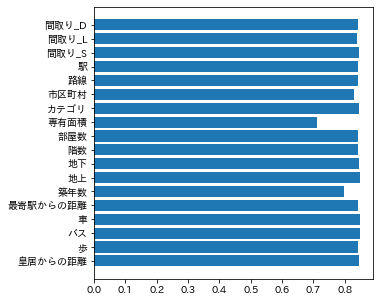

In [535]:
# 3個削除　test: 0.8486947200144128
plt.figure(figsize=(5,5))
plt.barh(scores['feature'],scores['r2_test'])
plt.show()

In [536]:
# 準備フェイズ
# 階をなかったことにする

# 事前のデータ加工なし
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
    '歩',
    'バス',
    '車',
    '最寄駅からの距離',
    '築年数',
#    '地上',
    '地下',
    '階数',
#    '階',
    '部屋数', 
    '専有面積',
]
category_features = [
    'カテゴリ',
    '市区町村',
    '路線',
    '駅',
#    '間取り',
]
is_features = [
    '間取り_S', 
    '間取り_L', 
    '間取り_D', 
#    '間取り_K',
]
target_feature = '賃料'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [537]:
# 賃料に対数変換を施す
suumo_light['賃料'] = np.log10(suumo_light['賃料'])

In [538]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]

# 学習用とテスト用に分割
train_test = 0.1
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [539]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    random_state = 0,
    importance_type = 'gain'
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0297717
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0250704
[3]	valid_0's l2: 0.0213521
[4]	valid_0's l2: 0.0182475
[5]	valid_0's l2: 0.0156699
[6]	valid_0's l2: 0.0134938
[7]	valid_0's l2: 0.01169
[8]	valid_0's l2: 0.0102466
[9]	valid_0's l2: 0.00900381
[10]	valid_0's l2: 0.0079639
[11]	valid_0's l2: 0.00710356
[12]	valid_0's l2: 0.00634631
[13]	valid_0's l2: 0.00573023
[14]	valid_0's l2: 0.00521765
[15]	valid_0's l2: 0.00480425
[16]	valid_0's l2: 0.00445485
[17]	valid_0's l2: 0.00414668
[18]	valid_0's l2: 0.00388149
[19]	valid_0's l2: 0.00365323
[20]	valid_0's l2: 0.00347102
[21]	valid_0's l2: 0.00330699
[22]	valid_0's l2: 0.00317156
[23]	valid_0's l2: 0.00305198
[24]	valid_0's l2: 0.00295325
[25]	valid_0's l2: 0.0028639
[26]	valid_0's l2: 0.00278167
[27]	valid_0's l2: 0.00271182
[28]	valid_0's l2: 0.00265467
[29]	valid_0's l2: 0.00259944
[30]	valid_0's l2: 0.00255506
[31]	valid_0's l2: 0.00251188
[32]	valid_0's l2: 0.00247376


LGBMRegressor(importance_type='gain', random_state=0)

In [540]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [541]:
# それぞれのr2スコアを算出
# 対数から元に戻そう
print('train:',r2_score(10**y_train,10**y_train_pred))
print('valid:',r2_score(10**y_valid,10**y_valid_pred))
print('test:',r2_score(10**y_test,10**y_test_pred))

train: 0.9500170810022514
valid: 0.8854078822315987
test: 0.8490254419607466


In [542]:
# それぞれのMSEを算出
# 対数から元に戻そう
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 3.1592830816269712
valid: 5.005061197598261
test: 10.249925736819439


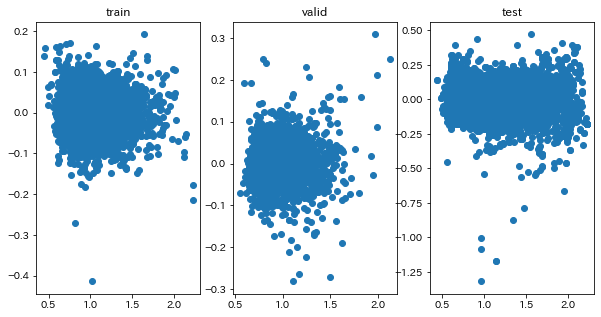

In [543]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, (y_train_pred - y_train))
ax1.title.set_text('train')
ax2.scatter(y_valid_pred, (y_valid_pred - y_valid))
ax2.title.set_text('valid')
ax3.scatter(y_test_pred, (y_test_pred - y_test))
ax3.title.set_text('test')

plt.show()

In [544]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[features, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances

,feature,importance
0,皇居からの距離,41.809152
1,歩,6.744176
2,バス,0.028890
3,車,0.000000
4,最寄駅からの距離,5.117975
5,築年数,149.734004
6,地下,1.278098
7,階数,62.557954
8,部屋数,2.603092
9,専有面積,952.865057


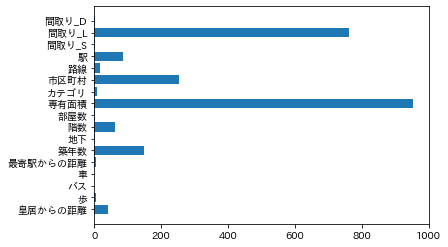

In [545]:
# 変数重要度
# 線形回帰ほどの介護は必要ないらしい
plt.barh(table_importances['feature'],table_importances['importance'])
plt.show()

# 不要な変数を減らしたい　5個目

結論：バス変数が不要。母数が少ない？実質最寄り駅だから？

In [546]:
# 必要ならデータ加工(未知データに対して実行できないものはやらない)
# シャッフルしてtrainとtestに分ける
# 調整が必要ならtrainをさらにtrainとvalidに分ける
# 必要ならデータ加工
# モデル構築
# モデル学習
# 学習を評価

In [547]:
# 準備フェイズ

# 事前のデータ加工なし
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
    '歩',  
    'バス',  
    '車',  
    '最寄駅からの距離',  
    '築年数',
#    '地上',
    '地下', 
    '階数',
#    '階',  
    '部屋数',  
    '専有面積',
]
category_features = [
    'カテゴリ',  
    '市区町村',
    '路線',
    '駅',
#    '間取り',
]
is_features = [
    '間取り_S',  
    '間取り_L', 
    '間取り_D',  
#    '間取り_K',  
]
target_feature = '賃料'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [548]:
# 賃料に対数変換を施す
suumo_light['賃料'] = np.log10(suumo_light['賃料'])

In [549]:
# スコアを貯める器
table_score = []

# 変数を1つ削除してスコアを検証するぞ
for i in tqdm(range(len(features))):
    features_list = features.tolist()
    drop = features_list.pop(i)
    
    # スコアの器
    score = []
    score.append(drop)

    
    # Xとyを定義
    X = suumo_light[features_list]
    y = suumo_light[target_feature]

    # 学習用とテスト用に分割
    train_test = 0.1
    train_valid = 0.8

    X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

    # モデルを構築、学習
    LGBM = lgb.LGBMRegressor(
        random_state = 0,
        importance_type = 'gain'
    )

    verbose_eval = 0
    LGBM.fit(X_train,y_train,
            eval_set=[(X_valid,y_valid)],
            eval_metric = 'mse',
            callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                        lgb.log_evaluation(verbose_eval)])

    # それぞれの予測結果を収納
    y_train_pred = LGBM.predict(X_train)
    y_valid_pred = LGBM.predict(X_valid)
    y_test_pred = LGBM.predict(X_test)

    # それぞれのr2スコアを算出
    # 対数から元に戻そう
    score.append(r2_score(10**y_train,10**y_train_pred))
    score.append(r2_score(10**y_valid,10**y_valid_pred))
    score.append(r2_score(10**y_test,10**y_test_pred))

    # それぞれのMSEを算出
    # 対数から元に戻そう
    score.append(mean_squared_error(10**y_train,10**y_train_pred))
    score.append(mean_squared_error(10**y_valid,10**y_valid_pred))
    score.append(mean_squared_error(10**y_test,10**y_test_pred))
    
    # スコアを器に入れる
    table_score.append(score)

  0%|          | 0/17 [00:00<?, ?it/s]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00209589


  6%|▌         | 1/17 [00:08<02:08,  8.04s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.00209795


 12%|█▏        | 2/17 [00:09<01:03,  4.23s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00206305


 18%|█▊        | 3/17 [00:11<00:41,  2.95s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00205132


 24%|██▎       | 4/17 [00:12<00:29,  2.31s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00205517


 29%|██▉       | 5/17 [00:13<00:23,  1.93s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00375402


 35%|███▌      | 6/17 [00:14<00:18,  1.64s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.00206924


 41%|████      | 7/17 [00:15<00:14,  1.49s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's l2: 0.00216422


 47%|████▋     | 8/17 [00:16<00:12,  1.37s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00204977


 53%|█████▎    | 9/17 [00:18<00:10,  1.32s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.00472562


 59%|█████▉    | 10/17 [00:19<00:08,  1.27s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00205627


 65%|██████▍   | 11/17 [00:20<00:07,  1.26s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00208198


 71%|███████   | 12/17 [00:21<00:06,  1.26s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00206719


 76%|███████▋  | 13/17 [00:23<00:04,  1.23s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00207946


 82%|████████▏ | 14/17 [00:24<00:03,  1.24s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00204238


 88%|████████▊ | 15/17 [00:25<00:02,  1.28s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0020589


 94%|█████████▍| 16/17 [00:26<00:01,  1.29s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.002057


100%|██████████| 17/17 [00:28<00:00,  1.66s/it]


In [552]:
# 変数を1つ減らしたスコアのテーブルを作成
scores = pd.DataFrame(table_score,columns=['feature','r2_train','r2_valid',"r2_test",'mse_train','mse_valid','mse_test'])
scores[['feature','r2_test']].sort_values('r2_test',ascending=False)

,feature,r2_test
2,バス,0.849653
0,皇居からの距離,0.849604
3,車,0.849025
14,間取り_S,0.846330
10,カテゴリ,0.846004
6,地下,0.845458
1,歩,0.845374
4,最寄駅からの距離,0.845003
8,部屋数,0.844694
16,間取り_D,0.844496


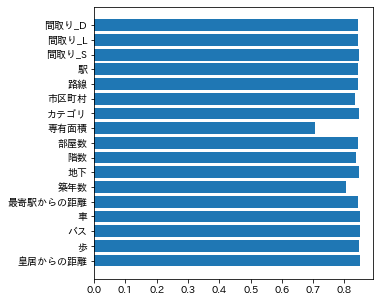

In [553]:
# 4個削除　test: 0.8490254419607466
plt.figure(figsize=(5,5))
plt.barh(scores['feature'],scores['r2_test'])
plt.show()

In [554]:
# 準備フェイズ
# 階をなかったことにする

# 事前のデータ加工なし
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
    '歩',
#    'バス',
    '車',
    '最寄駅からの距離',
    '築年数',
#    '地上',
    '地下',
    '階数',
#    '階',
    '部屋数', 
    '専有面積',
]
category_features = [
    'カテゴリ',
    '市区町村',
    '路線',
    '駅',
#    '間取り',
]
is_features = [
    '間取り_S', 
    '間取り_L', 
    '間取り_D', 
#    '間取り_K',
]
target_feature = '賃料'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [555]:
# 賃料に対数変換を施す
suumo_light['賃料'] = np.log10(suumo_light['賃料'])

In [556]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]

# 学習用とテスト用に分割
train_test = 0.1
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [557]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    random_state = 0,
    importance_type = 'gain'
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0297717
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0250704
[3]	valid_0's l2: 0.0213521
[4]	valid_0's l2: 0.0182475
[5]	valid_0's l2: 0.0156699
[6]	valid_0's l2: 0.0134938
[7]	valid_0's l2: 0.01169
[8]	valid_0's l2: 0.0102466
[9]	valid_0's l2: 0.00900381
[10]	valid_0's l2: 0.0079639
[11]	valid_0's l2: 0.00710356
[12]	valid_0's l2: 0.00634631
[13]	valid_0's l2: 0.00573023
[14]	valid_0's l2: 0.00521765
[15]	valid_0's l2: 0.00480425
[16]	valid_0's l2: 0.00445485
[17]	valid_0's l2: 0.00414668
[18]	valid_0's l2: 0.00388149
[19]	valid_0's l2: 0.00365323
[20]	valid_0's l2: 0.00347102
[21]	valid_0's l2: 0.00330699
[22]	valid_0's l2: 0.00317156
[23]	valid_0's l2: 0.00305198
[24]	valid_0's l2: 0.00295325
[25]	valid_0's l2: 0.0028639
[26]	valid_0's l2: 0.00278167
[27]	valid_0's l2: 0.00271182
[28]	valid_0's l2: 0.00265467
[29]	valid_0's l2: 0.00259944
[30]	valid_0's l2: 0.00255506
[31]	valid_0's l2: 0.00251188
[32]	valid_0's l2: 0.00247376


LGBMRegressor(importance_type='gain', random_state=0)

In [558]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [559]:
# それぞれのr2スコアを算出
# 対数から元に戻そう
print('train:',r2_score(10**y_train,10**y_train_pred))
print('valid:',r2_score(10**y_valid,10**y_valid_pred))
print('test:',r2_score(10**y_test,10**y_test_pred))

train: 0.9519848523578971
valid: 0.8819235706994708
test: 0.8496532540791567


In [560]:
# それぞれのMSEを算出
# 対数から元に戻そう
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 3.0349056567574486
valid: 5.157246119121776
test: 10.207302478477418


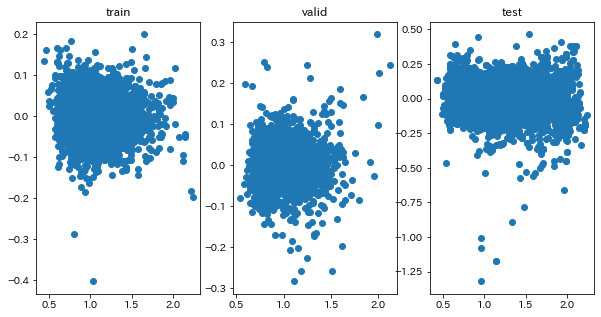

In [561]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, (y_train_pred - y_train))
ax1.title.set_text('train')
ax2.scatter(y_valid_pred, (y_valid_pred - y_valid))
ax2.title.set_text('valid')
ax3.scatter(y_test_pred, (y_test_pred - y_test))
ax3.title.set_text('test')

plt.show()

In [562]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[features, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances

,feature,importance
0,皇居からの距離,41.832915
1,歩,6.650721
2,車,0.000000
3,最寄駅からの距離,5.260127
4,築年数,149.575369
5,地下,1.236469
6,階数,62.576416
7,部屋数,2.512110
8,専有面積,952.632877
9,カテゴリ,7.426811


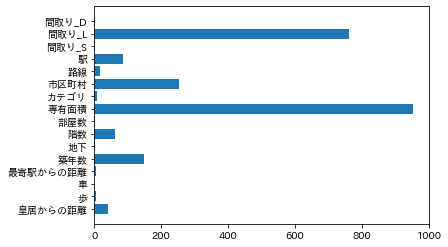

In [563]:
# 変数重要度
# 線形回帰ほどの介護は必要ないらしい
plt.barh(table_importances['feature'],table_importances['importance'])
plt.show()

# 不要な変数を減らしたい　6個目

結論：車変数が不要。最初から無意味だと言われ続けてきました。

In [546]:
# 必要ならデータ加工(未知データに対して実行できないものはやらない)
# シャッフルしてtrainとtestに分ける
# 調整が必要ならtrainをさらにtrainとvalidに分ける
# 必要ならデータ加工
# モデル構築
# モデル学習
# 学習を評価

In [564]:
# 準備フェイズ

# 事前のデータ加工なし
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
    '歩',  
#    'バス',  
    '車',  
    '最寄駅からの距離',  
    '築年数',
#    '地上',
    '地下', 
    '階数',
#    '階',  
    '部屋数',  
    '専有面積',
]
category_features = [
    'カテゴリ',  
    '市区町村',
    '路線',
    '駅',
#    '間取り',
]
is_features = [
    '間取り_S',  
    '間取り_L', 
    '間取り_D',  
#    '間取り_K',  
]
target_feature = '賃料'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [565]:
# 賃料に対数変換を施す
suumo_light['賃料'] = np.log10(suumo_light['賃料'])

In [566]:
# スコアを貯める器
table_score = []

# 変数を1つ削除してスコアを検証するぞ
for i in tqdm(range(len(features))):
    features_list = features.tolist()
    drop = features_list.pop(i)
    
    # スコアの器
    score = []
    score.append(drop)

    
    # Xとyを定義
    X = suumo_light[features_list]
    y = suumo_light[target_feature]

    # 学習用とテスト用に分割
    train_test = 0.1
    train_valid = 0.8

    X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

    # モデルを構築、学習
    LGBM = lgb.LGBMRegressor(
        random_state = 0,
        importance_type = 'gain'
    )

    verbose_eval = 0
    LGBM.fit(X_train,y_train,
            eval_set=[(X_valid,y_valid)],
            eval_metric = 'mse',
            callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                        lgb.log_evaluation(verbose_eval)])

    # それぞれの予測結果を収納
    y_train_pred = LGBM.predict(X_train)
    y_valid_pred = LGBM.predict(X_valid)
    y_test_pred = LGBM.predict(X_test)

    # それぞれのr2スコアを算出
    # 対数から元に戻そう
    score.append(r2_score(10**y_train,10**y_train_pred))
    score.append(r2_score(10**y_valid,10**y_valid_pred))
    score.append(r2_score(10**y_test,10**y_test_pred))

    # それぞれのMSEを算出
    # 対数から元に戻そう
    score.append(mean_squared_error(10**y_train,10**y_train_pred))
    score.append(mean_squared_error(10**y_valid,10**y_valid_pred))
    score.append(mean_squared_error(10**y_test,10**y_test_pred))
    
    # スコアを器に入れる
    table_score.append(score)

  0%|          | 0/16 [00:00<?, ?it/s]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00211215


  6%|▋         | 1/16 [00:01<00:18,  1.23s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.00209795


 12%|█▎        | 2/16 [00:02<00:16,  1.21s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00206305


 19%|█▉        | 3/16 [00:03<00:15,  1.20s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00206005


 25%|██▌       | 4/16 [00:04<00:14,  1.21s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00376816


 31%|███▏      | 5/16 [00:05<00:12,  1.16s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.00205888


 38%|███▊      | 6/16 [00:07<00:11,  1.19s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.002171


 44%|████▍     | 7/16 [00:08<00:10,  1.20s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00204555


 50%|█████     | 8/16 [00:09<00:09,  1.19s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[82]	valid_0's l2: 0.00472238


 56%|█████▋    | 9/16 [00:10<00:08,  1.15s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's l2: 0.00205134


 62%|██████▎   | 10/16 [00:11<00:06,  1.14s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00208603


 69%|██████▉   | 11/16 [00:12<00:05,  1.18s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's l2: 0.00207126


 75%|███████▌  | 12/16 [00:14<00:05,  1.29s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00208617


 81%|████████▏ | 13/16 [00:15<00:03,  1.30s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00206214


 88%|████████▊ | 14/16 [00:17<00:02,  1.33s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00206459


 94%|█████████▍| 15/16 [00:18<00:01,  1.28s/it]C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00203782


100%|██████████| 16/16 [00:19<00:00,  1.22s/it]


In [567]:
# 変数を1つ減らしたスコアのテーブルを作成
scores = pd.DataFrame(table_score,columns=['feature','r2_train','r2_valid',"r2_test",'mse_train','mse_valid','mse_test'])
scores[['feature','r2_test']].sort_values('r2_test',ascending=False)

,feature,r2_test
2,車,0.849653
0,皇居からの距離,0.848146
14,間取り_L,0.847134
5,地下,0.846875
3,最寄駅からの距離,0.846713
13,間取り_S,0.846539
9,カテゴリ,0.846367
1,歩,0.845374
12,駅,0.844891
15,間取り_D,0.844351


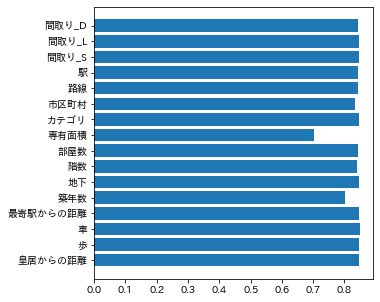

In [568]:
# 5個削除　test: 0.8496532540791567
plt.figure(figsize=(5,5))
plt.barh(scores['feature'],scores['r2_test'])
plt.show()

In [569]:
# 準備フェイズ
# 階をなかったことにする

# 事前のデータ加工なし
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
    '歩',
#    'バス',
#    '車',
    '最寄駅からの距離',
    '築年数',
#    '地上',
    '地下',
    '階数',
#    '階',
    '部屋数', 
    '専有面積',
]
category_features = [
    'カテゴリ',
    '市区町村',
    '路線',
    '駅',
#    '間取り',
]
is_features = [
    '間取り_S', 
    '間取り_L', 
    '間取り_D', 
#    '間取り_K',
]
target_feature = '賃料'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [570]:
# 賃料に対数変換を施す
suumo_light['賃料'] = np.log10(suumo_light['賃料'])

In [571]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]

# 学習用とテスト用に分割
train_test = 0.1
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [572]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    random_state = 0,
    importance_type = 'gain'
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0297717
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0250704
[3]	valid_0's l2: 0.0213521
[4]	valid_0's l2: 0.0182475
[5]	valid_0's l2: 0.0156699
[6]	valid_0's l2: 0.0134938
[7]	valid_0's l2: 0.01169
[8]	valid_0's l2: 0.0102466
[9]	valid_0's l2: 0.00900381
[10]	valid_0's l2: 0.0079639
[11]	valid_0's l2: 0.00710356
[12]	valid_0's l2: 0.00634631
[13]	valid_0's l2: 0.00573023
[14]	valid_0's l2: 0.00521765
[15]	valid_0's l2: 0.00480425
[16]	valid_0's l2: 0.00445485
[17]	valid_0's l2: 0.00414668
[18]	valid_0's l2: 0.00388149
[19]	valid_0's l2: 0.00365323
[20]	valid_0's l2: 0.00347102
[21]	valid_0's l2: 0.00330699
[22]	valid_0's l2: 0.00317156
[23]	valid_0's l2: 0.00305198
[24]	valid_0's l2: 0.00295325
[25]	valid_0's l2: 0.0028639
[26]	valid_0's l2: 0.00278167
[27]	valid_0's l2: 0.00271182
[28]	valid_0's l2: 0.00265467
[29]	valid_0's l2: 0.00259944
[30]	valid_0's l2: 0.00255506
[31]	valid_0's l2: 0.00251188
[32]	valid_0's l2: 0.00247376


LGBMRegressor(importance_type='gain', random_state=0)

In [573]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [574]:
# それぞれのr2スコアを算出
# 対数から元に戻そう
print('train:',r2_score(10**y_train,10**y_train_pred))
print('valid:',r2_score(10**y_valid,10**y_valid_pred))
print('test:',r2_score(10**y_test,10**y_test_pred))

train: 0.9519848523578971
valid: 0.8819235706994708
test: 0.8496532540791567


In [575]:
# それぞれのMSEを算出
# 対数から元に戻そう
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 3.0349056567574486
valid: 5.157246119121776
test: 10.207302478477418


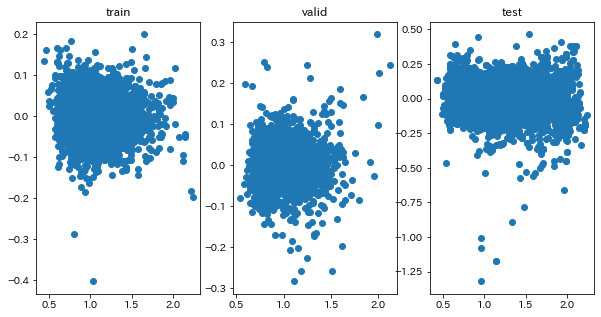

In [576]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, (y_train_pred - y_train))
ax1.title.set_text('train')
ax2.scatter(y_valid_pred, (y_valid_pred - y_valid))
ax2.title.set_text('valid')
ax3.scatter(y_test_pred, (y_test_pred - y_test))
ax3.title.set_text('test')

plt.show()

In [577]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[features, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances

,feature,importance
0,皇居からの距離,41.832915
1,歩,6.650721
2,最寄駅からの距離,5.260127
3,築年数,149.575369
4,地下,1.236469
5,階数,62.576416
6,部屋数,2.512110
7,専有面積,952.632877
8,カテゴリ,7.426811
9,市区町村,254.068053


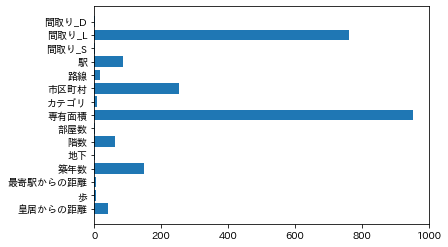

In [578]:
# 変数重要度
# 線形回帰ほどの介護は必要ないらしい
plt.barh(table_importances['feature'],table_importances['importance'])
plt.show()

# 不要な変数を減らしたい　最初から最後まで

結論：それなりの精度で予測するってだけなら変数をかなり削ることができる。

とはいえ、他の変数と組み合わさることで機能するもの、他の変数を削ったときに代わりになってくれるもの、とかあり得るもので。

In [8]:
# 必要ならデータ加工(未知データに対して実行できないものはやらない)
# シャッフルしてtrainとtestに分ける
# 調整が必要ならtrainをさらにtrainとvalidに分ける
# 必要ならデータ加工
# モデル構築
# モデル学習
# 学習を評価

In [9]:
# 準備フェイズ

# 事前のデータ加工なし
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
    '歩',
    'バス',
    '車',
    '最寄駅からの距離',
    '築年数',
    '地上',
    '地下',
    '階数',
    '階',
    '部屋数',
    '専有面積',
]
category_features = [
    'カテゴリ',
    '市区町村',
    '路線',
    '駅',
    '間取り',
]
is_features = [
    '間取り_S',
    '間取り_L',
    '間取り_D',
    '間取り_K',
]
target_feature = '賃料'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [10]:
# 賃料に対数変換を施す
suumo_light['賃料'] = np.log10(suumo_light['賃料'])

In [11]:
# スコア遷移をつかさどる器
score_transition = []


num = len(features)
# featuresを1つずつ減らしながら検証するゾ
for j in range(num):
    
    # スコアを貯める器
    table_score = []

    # 変数を1つ削除してスコアを検証するぞ
    for i in range(len(features)):
        features_list = features.tolist()
        drop = features_list.pop(i)
        print(features)

        # スコアの器
        score = []
        score.append(drop)

        # Xとyを定義
        X = suumo_light[features_list]
        y = suumo_light[target_feature]

        # 学習用とテスト用に分割
        train_test = 0.5
        train_valid = 0.8
        X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

        # モデルを構築、学習
        LGBM = lgb.LGBMRegressor(
            n_estimators = 1000,
            random_state = 0,
            importance_type = 'gain'
        )

        verbose_eval = 0
        LGBM.fit(X_train,y_train,
                eval_set=[(X_valid,y_valid)],
                eval_metric = 'mse',
                callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                            lgb.log_evaluation(verbose_eval)])

        # それぞれの予測結果を収納
        y_test_pred = LGBM.predict(X_test)

        # それぞれのr2スコアを算出
        # 対数から元に戻そう
        score.append(r2_score(10**y_test,10**y_test_pred))

        # それぞれのMSEを算出
        # 対数から元に戻そう
        # score.append(mean_squared_error(10**y_test,10**y_test_pred))

        # スコアを器に入れる
        table_score.append(score)

    # 変数を1つ減らしたスコアのテーブルを作成
    scores = pd.DataFrame(table_score,columns=['feature',"r2_test"])

    # スコアが高い変数とスコアを保存
    id_ = scores['r2_test'].idxmax()
    max_feature = scores.loc[id_,'feature']
    max_ = scores['r2_test'].max()
    score_transition.append([max_feature,max_])

    # スコアが高い変数を削除
    features = np.delete(features,id_)
    print(features)

['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '駅' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00148251
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '駅' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00149043
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '駅' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00145989
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '駅' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00146047
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '駅' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[880]	valid_0's l2: 0.00148322
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '駅' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00257344
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '駅' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00146794
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '駅' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00146121
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '駅' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00147058
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '駅' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00150797
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '駅' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00145577
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '駅' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00349906
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '駅' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00147527
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '駅' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00147404
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '駅' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's l2: 0.0014573
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '駅' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00147996
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '駅' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00147387
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '駅' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00146282
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '駅' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[921]	valid_0's l2: 0.00147865
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '駅' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00146521
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '駅' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00146857
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00158235
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0015104
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00148823
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00147996
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00149063
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00261689
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00146753
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.001459
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00148219
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00152381
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00148038
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00350107
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00148781
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00173034
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00154821
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00148847
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00148116
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00148454
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00147169
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_L' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00147343
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00159744
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0015043
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00148517
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00148454
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00147724
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0026399
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00146659
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00147531
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00147357
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00152299
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00147538
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00351453
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00148351
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0017245
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0015475
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00148212
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00148079
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00146711
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00148027
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00159744
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0015043
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00148517
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00147724
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0026399
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00146659
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00147531
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00147357
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00152299
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00147538
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00351453
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00148351
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0017245
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0015475
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00148212
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00148079
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00146711
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '階' '部屋数' '専有面積'
 'カテゴリ' '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00148027
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00164142
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00154384
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00151677
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00153037
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00264444
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00152103
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0015245
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00153048
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00151236
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00360077
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00153499
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00177314
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00159551
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00156108
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00151535
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00152993
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D' '間取り_K']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00152115
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D']
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00162748
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00155711
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00152283
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00154048
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00263278
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00151599
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00151354
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00152639
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00151142
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 0.00359974
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0015415
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00174958
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0015924
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00156324
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00152994
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ'
 '市区町村' '路線' '間取り' '間取り_S' '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00152551
['皇居からの距離' '歩' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村'
 '路線' '間取り' '間取り_S' '間取り_D']
['皇居からの距離' '歩' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村'
 '路線' '間取り' '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00163059
['皇居からの距離' '歩' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村'
 '路線' '間取り' '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00155802
['皇居からの距離' '歩' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村'
 '路線' '間取り' '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00155061
['皇居からの距離' '歩' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村'
 '路線' '間取り' '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0026422
['皇居からの距離' '歩' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村'
 '路線' '間取り' '間取り_S' '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's l2: 0.00153375
['皇居からの距離' '歩' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村'
 '路線' '間取り' '間取り_S' '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00151715
['皇居からの距離' '歩' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村'
 '路線' '間取り' '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00152665
['皇居からの距離' '歩' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村'
 '路線' '間取り' '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')



Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0015134
['皇居からの距離' '歩' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村'
 '路線' '間取り' '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00360217
['皇居からの距離' '歩' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村'
 '路線' '間取り' '間取り_S' '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00154311
['皇居からの距離' '歩' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村'
 '路線' '間取り' '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00177648
['皇居からの距離' '歩' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村'
 '路線' '間取り' '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00158713
['皇居からの距離' '歩' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村'
 '路線' '間取り' '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00156662
['皇居からの距離' '歩' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村'
 '路線' '間取り' '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00152423
['皇居からの距離' '歩' '最寄駅からの距離' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村'
 '路線' '間取り' '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00152182
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_S' '間取り_D']
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00170645
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00161124
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00267247
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00155122
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_S' '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00154066
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00154294
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_S' '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00154383
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00362595
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00155814
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00184391
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0016345
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00157984
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0015449
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_S' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0015472
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00170397
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00159777
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00267855
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00154584
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00153063
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00154386
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00155475
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00363525
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00155786
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00184884
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00163219
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's l2: 0.00157411
['皇居からの距離' '歩' '築年数' '地上' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00155173
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0017107
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0016208
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00269376
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00154249
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0016692
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00153795
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[997]	valid_0's l2: 0.00365303
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00155429
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00184995
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00164817
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00156625
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '路線' '間取り'
 '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00154992
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り' '間取り_D']
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00202759
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り' '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00169043
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00284378
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00164255
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00176407
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00164361
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00379615
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00165854
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00285791
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00166443
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00165752
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00205447
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00170706
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00288906
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00165012
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.001793
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00168001
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00461428
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00167203
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00288757
['皇居からの距離' '歩' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00169189
['皇居からの距離' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
['皇居からの距離' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00217979
['皇居からの距離' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00300504
['皇居からの距離' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00172059
['皇居からの距離' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.001848
['皇居からの距離' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00174356
['皇居からの距離' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00469809
['皇居からの距離' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00171724
['皇居からの距離' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0030927
['皇居からの距離' '築年数' '地下' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0017338
['皇居からの距離' '築年数' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
['皇居からの距離' '築年数' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[583]	valid_0's l2: 0.0022716
['皇居からの距離' '築年数' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0030172
['皇居からの距離' '築年数' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0018715
['皇居からの距離' '築年数' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[970]	valid_0's l2: 0.00173929
['皇居からの距離' '築年数' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00475929
['皇居からの距離' '築年数' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0017362
['皇居からの距離' '築年数' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00317871
['皇居からの距離' '築年数' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村' '間取り_D']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00172905
['皇居からの距離' '築年数' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村']
['皇居からの距離' '築年数' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[890]	valid_0's l2: 0.002234
['皇居からの距離' '築年数' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0030606
['皇居からの距離' '築年数' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[711]	valid_0's l2: 0.00195833
['皇居からの距離' '築年数' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00176124
['皇居からの距離' '築年数' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 0.00831642
['皇居からの距離' '築年数' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00175812
['皇居からの距離' '築年数' '階数' '部屋数' '専有面積' 'カテゴリ' '市区町村']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00318737
['皇居からの距離' '築年数' '階数' '部屋数' '専有面積' '市区町村']
['皇居からの距離' '築年数' '階数' '部屋数' '専有面積' '市区町村']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00223203
['皇居からの距離' '築年数' '階数' '部屋数' '専有面積' '市区町村']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00309438
['皇居からの距離' '築年数' '階数' '部屋数' '専有面積' '市区町村']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00202838
['皇居からの距離' '築年数' '階数' '部屋数' '専有面積' '市区町村']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00177652
['皇居からの距離' '築年数' '階数' '部屋数' '専有面積' '市区町村']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00869081
['皇居からの距離' '築年数' '階数' '部屋数' '専有面積' '市区町村']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00322665
['皇居からの距離' '築年数' '階数' '専有面積' '市区町村']
['皇居からの距離' '築年数' '階数' '専有面積' '市区町村']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[851]	valid_0's l2: 0.00227681
['皇居からの距離' '築年数' '階数' '専有面積' '市区町村']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[860]	valid_0's l2: 0.00330726
['皇居からの距離' '築年数' '階数' '専有面積' '市区町村']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[551]	valid_0's l2: 0.00218337
['皇居からの距離' '築年数' '階数' '専有面積' '市区町村']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0164468
['皇居からの距離' '築年数' '階数' '専有面積' '市区町村']
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00324276
['築年数' '階数' '専有面積' '市区町村']
['築年数' '階数' '専有面積' '市区町村']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[980]	valid_0's l2: 0.00413519
['築年数' '階数' '専有面積' '市区町村']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[788]	valid_0's l2: 0.00288637
['築年数' '階数' '専有面積' '市区町村']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[652]	valid_0's l2: 0.0190487
['築年数' '階数' '専有面積' '市区町村']
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[664]	valid_0's l2: 0.00522375
['築年数' '専有面積' '市区町村']
['築年数' '専有面積' '市区町村']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[371]	valid_0's l2: 0.00545284
['築年数' '専有面積' '市区町村']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[207]	valid_0's l2: 0.02503
['築年数' '専有面積' '市区町村']
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[513]	valid_0's l2: 0.00761546
['専有面積' '市区町村']
['専有面積' '市区町村']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[191]	valid_0's l2: 0.0295405
['専有面積' '市区町村']
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[154]	valid_0's l2: 0.0113513
['専有面積']
['専有面積']
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.991666
[]


In [12]:
table_drop_feature = pd.DataFrame(score_transition,columns=['features','score'])
table_drop_feature

,features,score
0,駅,0.911920
1,間取り_L,0.912453
2,車,0.912453
3,階,0.912255
4,間取り_K,0.910004
5,バス,0.911029
6,最寄駅からの距離,0.910698
7,間取り_S,0.910625
8,地上,0.910996
9,路線,0.911421


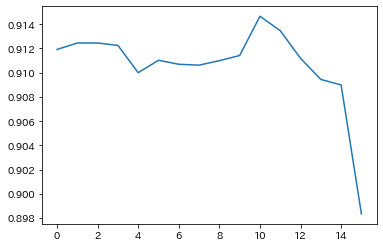

In [13]:
# 上がった後下がり続けるってわけでもない
plt.plot(table_drop_feature.loc[:15,'score'])
plt.show()

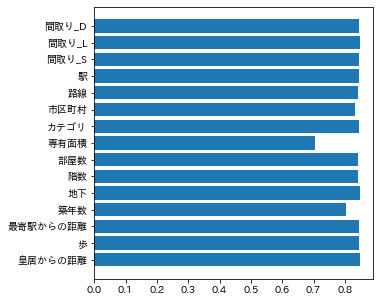

In [583]:
# 5個削除　test: 0.8496532540791567
plt.figure(figsize=(5,5))
plt.barh(scores['feature'],scores['r2_test'])
plt.show()

In [892]:
# 準備フェイズ
# 10個くらいなくても変わんなくね？という思想。

# 事前のデータ加工なし
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
#    '皇居からの距離',
#    '歩',
#    'バス',
#    '車',
    '最寄駅からの距離',
    '築年数',
#    '地上',
#    '地下',
    '階数',
#    '階',
#    '部屋数', 
    '専有面積',
]
category_features = [
#    'カテゴリ',
    '市区町村',
    '路線',
    '駅',
#    '間取り',
]
is_features = [
#    '間取り_S', 
    '間取り_L',
#    '間取り_D', 
#    '間取り_K',
]
target_feature = '賃料'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [893]:
# 賃料に対数変換を施す
suumo_light['賃料'] = np.log10(suumo_light['賃料'])

In [894]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]

# 学習用とテスト用に分割
train_test = 0.1
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [895]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    random_state = 0,
    importance_type = 'gain'
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0297445
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0250833
[3]	valid_0's l2: 0.02132
[4]	valid_0's l2: 0.0182097
[5]	valid_0's l2: 0.0156711
[6]	valid_0's l2: 0.0135081
[7]	valid_0's l2: 0.0117506
[8]	valid_0's l2: 0.0103032
[9]	valid_0's l2: 0.00906863
[10]	valid_0's l2: 0.00805158
[11]	valid_0's l2: 0.00718565
[12]	valid_0's l2: 0.00645641
[13]	valid_0's l2: 0.00582578
[14]	valid_0's l2: 0.00532294
[15]	valid_0's l2: 0.00488733
[16]	valid_0's l2: 0.00452559
[17]	valid_0's l2: 0.00421316
[18]	valid_0's l2: 0.00394653
[19]	valid_0's l2: 0.00374197
[20]	valid_0's l2: 0.00355508
[21]	valid_0's l2: 0.00339276
[22]	valid_0's l2: 0.00324509
[23]	valid_0's l2: 0.00312585
[24]	valid_0's l2: 0.00301917
[25]	valid_0's l2: 0.00292936
[26]	valid_0's l2: 0.00285489
[27]	valid_0's l2: 0.00278928
[28]	valid_0's l2: 0.00272202
[29]	valid_0's l2: 0.00266645
[30]	valid_0's l2: 0.00262452
[31]	valid_0's l2: 0.00258643
[32]	valid_0's l2: 0.002556


LGBMRegressor(importance_type='gain', random_state=0)

In [896]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [897]:
# それぞれのr2スコアを算出
# 対数から元に戻そう
print('train:',r2_score(10**y_train,10**y_train_pred))
print('valid:',r2_score(10**y_valid,10**y_valid_pred))
print('test:',r2_score(10**y_test,10**y_test_pred))

train: 0.9451586158109269
valid: 0.8764275972934084
test: 0.8449458588670338


In [898]:
# それぞれのMSEを算出
# 対数から元に戻そう
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 3.4663733274430677
valid: 5.397294769704447
test: 10.526895739519286


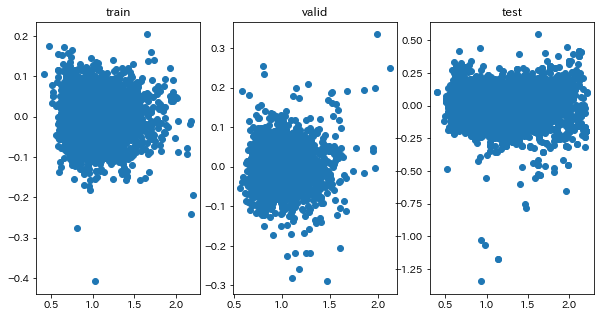

In [899]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, (y_train_pred - y_train))
ax1.title.set_text('train')
ax2.scatter(y_valid_pred, (y_valid_pred - y_valid))
ax2.title.set_text('valid')
ax3.scatter(y_test_pred, (y_test_pred - y_test))
ax3.title.set_text('test')

plt.show()

In [900]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[features, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances

,feature,importance
0,最寄駅からの距離,9.095100
1,築年数,150.307443
2,階数,80.388803
3,専有面積,952.317332
4,市区町村,273.434320
5,路線,19.281975
6,駅,92.082238
7,間取り_L,761.925089


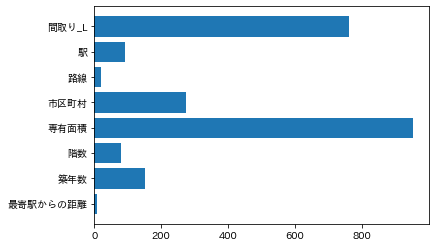

In [901]:
# 変数重要度
# 線形回帰ほどの介護は必要ないらしい
plt.barh(table_importances['feature'],table_importances['importance'])
plt.show()

# train_valid_testの比率で結果が変わるのか？

結論：学習データ7～8万件くらいがちょうどよさそう

In [720]:
# 必要ならデータ加工(未知データに対して実行できないものはやらない)
# シャッフルしてtrainとtestに分ける
# 調整が必要ならtrainをさらにtrainとvalidに分ける
# 必要ならデータ加工
# モデル構築
# モデル学習
# 学習を評価

In [785]:
# 準備フェイズ
# 変数は8個のみ採用

# 事前のデータ加工なし
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
#    '皇居からの距離',
#    '歩',
#    'バス',
#    '車',
    '最寄駅からの距離',
    '築年数',
#    '地上',
#    '地下',
    '階数',
#    '階',
#    '部屋数', 
    '専有面積',
]
category_features = [
#    'カテゴリ',
    '市区町村',
    '路線',
    '駅',
#    '間取り',
]
is_features = [
#    '間取り_S', 
    '間取り_L',
#    '間取り_D', 
#    '間取り_K',
]
target_feature = '賃料'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [786]:
# 賃料に対数変換を施す
suumo_light['賃料'] = np.log10(suumo_light['賃料'])

In [787]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]

# scoreを貯める器
scores = []

# trainとtestの比率を変えて検証
for i in range(9):
    # 学習用とテスト用に分割
    train_test = (i+1)/10
    train_valid = 0.8

    X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

    # モデルを構築、学習

    LGBM = lgb.LGBMRegressor(
        random_state = 0,
        importance_type = 'gain'
    )

    verbose_eval = 1
    LGBM.fit(X_train,y_train,
            eval_set=[(X_valid,y_valid)],
            eval_metric = 'mse',
            callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                        lgb.log_evaluation(verbose_eval)])

    # それぞれの予測結果を収納
    y_train_pred = LGBM.predict(X_train)
    y_valid_pred = LGBM.predict(X_valid)
    y_test_pred = LGBM.predict(X_test)

    # それぞれのr2スコアを算出
    # 対数から元に戻そう
    test_r2_score = r2_score(10**y_test,10**y_test_pred)
    score = {
        'ratio_train_test':train_test,
        'test_r2_score':test_r2_score
    }
    scores.append(score)

    # それぞれのMSEを算出
    # 対数から元に戻そう
    # print('test:',mean_squared_error(10**y_test,10**y_test_pred))

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0297445
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0250833
[3]	valid_0's l2: 0.02132
[4]	valid_0's l2: 0.0182097
[5]	valid_0's l2: 0.0156711
[6]	valid_0's l2: 0.0135081
[7]	valid_0's l2: 0.0117506
[8]	valid_0's l2: 0.0103032
[9]	valid_0's l2: 0.00906863
[10]	valid_0's l2: 0.00805158
[11]	valid_0's l2: 0.00718565
[12]	valid_0's l2: 0.00645641
[13]	valid_0's l2: 0.00582578
[14]	valid_0's l2: 0.00532294
[15]	valid_0's l2: 0.00488733
[16]	valid_0's l2: 0.00452559
[17]	valid_0's l2: 0.00421316
[18]	valid_0's l2: 0.00394653
[19]	valid_0's l2: 0.00374197
[20]	valid_0's l2: 0.00355508
[21]	valid_0's l2: 0.00339276
[22]	valid_0's l2: 0.00324509
[23]	valid_0's l2: 0.00312585
[24]	valid_0's l2: 0.00301917
[25]	valid_0's l2: 0.00292936
[26]	valid_0's l2: 0.00285489
[27]	valid_0's l2: 0.00278928
[28]	valid_0's l2: 0.00272202
[29]	valid_0's l2: 0.00266645
[30]	valid_0's l2: 0.00262452
[31]	valid_0's l2: 0.00258643
[32]	valid_0's l2: 0.002556


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0304985
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0259144
[3]	valid_0's l2: 0.0220882
[4]	valid_0's l2: 0.0189103
[5]	valid_0's l2: 0.0163216
[6]	valid_0's l2: 0.0141229
[7]	valid_0's l2: 0.012285
[8]	valid_0's l2: 0.010795
[9]	valid_0's l2: 0.00950911
[10]	valid_0's l2: 0.00844101
[11]	valid_0's l2: 0.00752974
[12]	valid_0's l2: 0.00676629
[13]	valid_0's l2: 0.00611862
[14]	valid_0's l2: 0.00559347
[15]	valid_0's l2: 0.00514443
[16]	valid_0's l2: 0.00474581
[17]	valid_0's l2: 0.00440817
[18]	valid_0's l2: 0.00411288
[19]	valid_0's l2: 0.00388117
[20]	valid_0's l2: 0.00368204
[21]	valid_0's l2: 0.00350302
[22]	valid_0's l2: 0.00334998
[23]	valid_0's l2: 0.00321049
[24]	valid_0's l2: 0.00309035
[25]	valid_0's l2: 0.00298803
[26]	valid_0's l2: 0.00290049
[27]	valid_0's l2: 0.00282476
[28]	valid_0's l2: 0.00275147
[29]	valid_0's l2: 0.00269147
[30]	valid_0's l2: 0.00263746
[31]	valid_0's l2: 0.00258828
[32]	valid_0's l2: 0.0025463

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0311687
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0264501
[3]	valid_0's l2: 0.0225507
[4]	valid_0's l2: 0.0193273
[5]	valid_0's l2: 0.0166167
[6]	valid_0's l2: 0.0144321
[7]	valid_0's l2: 0.0125601
[8]	valid_0's l2: 0.0109972
[9]	valid_0's l2: 0.00967916
[10]	valid_0's l2: 0.00862996
[11]	valid_0's l2: 0.0076909
[12]	valid_0's l2: 0.00691784
[13]	valid_0's l2: 0.00624946
[14]	valid_0's l2: 0.005705
[15]	valid_0's l2: 0.00524946
[16]	valid_0's l2: 0.00485004
[17]	valid_0's l2: 0.00450708
[18]	valid_0's l2: 0.00421472
[19]	valid_0's l2: 0.00396164
[20]	valid_0's l2: 0.00375565
[21]	valid_0's l2: 0.00357671
[22]	valid_0's l2: 0.00341789
[23]	valid_0's l2: 0.00327764
[24]	valid_0's l2: 0.00316269
[25]	valid_0's l2: 0.00305376
[26]	valid_0's l2: 0.00295692
[27]	valid_0's l2: 0.00288145
[28]	valid_0's l2: 0.00281051
[29]	valid_0's l2: 0.00274511
[30]	valid_0's l2: 0.00269092
[31]	valid_0's l2: 0.00264506
[32]	valid_0's l2: 0.00260253

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0306465
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.02597
[3]	valid_0's l2: 0.0221565
[4]	valid_0's l2: 0.0190194
[5]	valid_0's l2: 0.0163412
[6]	valid_0's l2: 0.0141439
[7]	valid_0's l2: 0.0123401
[8]	valid_0's l2: 0.0107945
[9]	valid_0's l2: 0.009509
[10]	valid_0's l2: 0.0084297
[11]	valid_0's l2: 0.00753749
[12]	valid_0's l2: 0.00680562
[13]	valid_0's l2: 0.0061786
[14]	valid_0's l2: 0.00562606
[15]	valid_0's l2: 0.00515662
[16]	valid_0's l2: 0.00477425
[17]	valid_0's l2: 0.00443459
[18]	valid_0's l2: 0.00415257
[19]	valid_0's l2: 0.00389876
[20]	valid_0's l2: 0.00368985
[21]	valid_0's l2: 0.00350279
[22]	valid_0's l2: 0.00334852
[23]	valid_0's l2: 0.00321675
[24]	valid_0's l2: 0.00309254
[25]	valid_0's l2: 0.00298746
[26]	valid_0's l2: 0.0028939
[27]	valid_0's l2: 0.00281662
[28]	valid_0's l2: 0.00274443
[29]	valid_0's l2: 0.00268228
[30]	valid_0's l2: 0.00262486
[31]	valid_0's l2: 0.00257284
[32]	valid_0's l2: 0.00252328
[33

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0314019
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0266223
[3]	valid_0's l2: 0.0226955
[4]	valid_0's l2: 0.0194574
[5]	valid_0's l2: 0.0167954
[6]	valid_0's l2: 0.014523
[7]	valid_0's l2: 0.012652
[8]	valid_0's l2: 0.0110867
[9]	valid_0's l2: 0.00975846
[10]	valid_0's l2: 0.00863743
[11]	valid_0's l2: 0.00769819
[12]	valid_0's l2: 0.00693008
[13]	valid_0's l2: 0.00628048
[14]	valid_0's l2: 0.00571282
[15]	valid_0's l2: 0.00523235
[16]	valid_0's l2: 0.00482897
[17]	valid_0's l2: 0.00448839
[18]	valid_0's l2: 0.00418123
[19]	valid_0's l2: 0.00392148
[20]	valid_0's l2: 0.00369556
[21]	valid_0's l2: 0.00350297
[22]	valid_0's l2: 0.00333564
[23]	valid_0's l2: 0.00318725
[24]	valid_0's l2: 0.0030691
[25]	valid_0's l2: 0.00295774
[26]	valid_0's l2: 0.00285808
[27]	valid_0's l2: 0.00276973
[28]	valid_0's l2: 0.00269984
[29]	valid_0's l2: 0.00263257
[30]	valid_0's l2: 0.00257761
[31]	valid_0's l2: 0.00252112
[32]	valid_0's l2: 0.00247544

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0301215
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0255037
[3]	valid_0's l2: 0.0217317
[4]	valid_0's l2: 0.0186144
[5]	valid_0's l2: 0.0159633
[6]	valid_0's l2: 0.0137811
[7]	valid_0's l2: 0.0120096
[8]	valid_0's l2: 0.0105051
[9]	valid_0's l2: 0.00922981
[10]	valid_0's l2: 0.00818153
[11]	valid_0's l2: 0.0072997
[12]	valid_0's l2: 0.00655515
[13]	valid_0's l2: 0.00593725
[14]	valid_0's l2: 0.00539391
[15]	valid_0's l2: 0.00493702
[16]	valid_0's l2: 0.00454967
[17]	valid_0's l2: 0.00422147
[18]	valid_0's l2: 0.00394725
[19]	valid_0's l2: 0.00369857
[20]	valid_0's l2: 0.00349386
[21]	valid_0's l2: 0.00331969
[22]	valid_0's l2: 0.00316825
[23]	valid_0's l2: 0.00302389
[24]	valid_0's l2: 0.00291201
[25]	valid_0's l2: 0.00281071
[26]	valid_0's l2: 0.00271978
[27]	valid_0's l2: 0.00264407
[28]	valid_0's l2: 0.0025721
[29]	valid_0's l2: 0.00250723
[30]	valid_0's l2: 0.00245456
[31]	valid_0's l2: 0.00240427
[32]	valid_0's l2: 0.0023595

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0312418
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0264782
[3]	valid_0's l2: 0.0225388
[4]	valid_0's l2: 0.0193208
[5]	valid_0's l2: 0.0166071
[6]	valid_0's l2: 0.0143963
[7]	valid_0's l2: 0.0125111
[8]	valid_0's l2: 0.0109522
[9]	valid_0's l2: 0.00963314
[10]	valid_0's l2: 0.00851806
[11]	valid_0's l2: 0.00759983
[12]	valid_0's l2: 0.00681015
[13]	valid_0's l2: 0.00615341
[14]	valid_0's l2: 0.00559668
[15]	valid_0's l2: 0.00514015
[16]	valid_0's l2: 0.00473719
[17]	valid_0's l2: 0.00439644
[18]	valid_0's l2: 0.00410512
[19]	valid_0's l2: 0.00384969
[20]	valid_0's l2: 0.00363424
[21]	valid_0's l2: 0.00345731
[22]	valid_0's l2: 0.00329238
[23]	valid_0's l2: 0.00315359
[24]	valid_0's l2: 0.00303275
[25]	valid_0's l2: 0.00292635
[26]	valid_0's l2: 0.00283634
[27]	valid_0's l2: 0.00275671
[28]	valid_0's l2: 0.00268787
[29]	valid_0's l2: 0.00262535
[30]	valid_0's l2: 0.00256906
[31]	valid_0's l2: 0.00251751
[32]	valid_0's l2: 0.00247

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0302539
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0256133
[3]	valid_0's l2: 0.0218032
[4]	valid_0's l2: 0.0186795
[5]	valid_0's l2: 0.0160409
[6]	valid_0's l2: 0.0138669
[7]	valid_0's l2: 0.0120782
[8]	valid_0's l2: 0.0105563
[9]	valid_0's l2: 0.00929481
[10]	valid_0's l2: 0.00823975
[11]	valid_0's l2: 0.00737532
[12]	valid_0's l2: 0.00663575
[13]	valid_0's l2: 0.00599752
[14]	valid_0's l2: 0.00545756
[15]	valid_0's l2: 0.00499552
[16]	valid_0's l2: 0.00460661
[17]	valid_0's l2: 0.00427262
[18]	valid_0's l2: 0.0039892
[19]	valid_0's l2: 0.00374956
[20]	valid_0's l2: 0.00354182
[21]	valid_0's l2: 0.00336359
[22]	valid_0's l2: 0.00321178
[23]	valid_0's l2: 0.00308233
[24]	valid_0's l2: 0.00296129
[25]	valid_0's l2: 0.00286135
[26]	valid_0's l2: 0.0027704
[27]	valid_0's l2: 0.0026921
[28]	valid_0's l2: 0.00262368
[29]	valid_0's l2: 0.00256184
[30]	valid_0's l2: 0.00250845
[31]	valid_0's l2: 0.00245996
[32]	valid_0's l2: 0.00241256

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0304384
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0257435
[3]	valid_0's l2: 0.0218885
[4]	valid_0's l2: 0.0187455
[5]	valid_0's l2: 0.0160808
[6]	valid_0's l2: 0.0138648
[7]	valid_0's l2: 0.0120613
[8]	valid_0's l2: 0.0105286
[9]	valid_0's l2: 0.00925641
[10]	valid_0's l2: 0.00821493
[11]	valid_0's l2: 0.00731846
[12]	valid_0's l2: 0.00656282
[13]	valid_0's l2: 0.00593151
[14]	valid_0's l2: 0.00537872
[15]	valid_0's l2: 0.00491939
[16]	valid_0's l2: 0.00451981
[17]	valid_0's l2: 0.00417996
[18]	valid_0's l2: 0.00390397
[19]	valid_0's l2: 0.00365366
[20]	valid_0's l2: 0.00344283
[21]	valid_0's l2: 0.00326048
[22]	valid_0's l2: 0.00310783
[23]	valid_0's l2: 0.00297388
[24]	valid_0's l2: 0.00285468
[25]	valid_0's l2: 0.00275719
[26]	valid_0's l2: 0.0026683
[27]	valid_0's l2: 0.00258429
[28]	valid_0's l2: 0.00251057
[29]	valid_0's l2: 0.0024498
[30]	valid_0's l2: 0.0023962
[31]	valid_0's l2: 0.00234585
[32]	valid_0's l2: 0.00230118

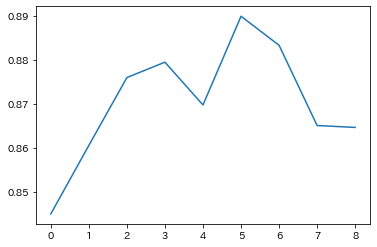

In [788]:
# trainとtestの比率で結構変わる？
# たぶん訓練で半分（7～8万）あればOK。
score_ratio = pd.DataFrame(scores)

plt.plot(score_ratio['test_r2_score'])
plt.show()

In [690]:
# 準備フェイズ
# 10個くらいなくても変わんなくね？という思想。

# 事前のデータ加工なし
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
#    '皇居からの距離',
#    '歩',
#    'バス',
#    '車',
    '最寄駅からの距離',
    '築年数',
#    '地上',
#    '地下',
    '階数',
#    '階',
#    '部屋数', 
    '専有面積',
]
category_features = [
#    'カテゴリ',
    '市区町村',
    '路線',
    '駅',
#    '間取り',
]
is_features = [
#    '間取り_S', 
    '間取り_L',
#    '間取り_D', 
#    '間取り_K',
]
target_feature = '賃料'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [691]:
# 賃料に対数変換を施す
suumo_light['賃料'] = np.log10(suumo_light['賃料'])

In [816]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]

# 学習用とテスト用に分割
# 学習データは半分くらいあればOKっぽい
train_test = 0.5
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [817]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    random_state = 0,
    importance_type = 'gain'
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0314019
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0266223
[3]	valid_0's l2: 0.0226955
[4]	valid_0's l2: 0.0194574
[5]	valid_0's l2: 0.0167954
[6]	valid_0's l2: 0.014523
[7]	valid_0's l2: 0.012652
[8]	valid_0's l2: 0.0110867
[9]	valid_0's l2: 0.00975846
[10]	valid_0's l2: 0.00863743
[11]	valid_0's l2: 0.00769819
[12]	valid_0's l2: 0.00693008
[13]	valid_0's l2: 0.00628048
[14]	valid_0's l2: 0.00571282
[15]	valid_0's l2: 0.00523235
[16]	valid_0's l2: 0.00482897
[17]	valid_0's l2: 0.00448839
[18]	valid_0's l2: 0.00418123
[19]	valid_0's l2: 0.00392148
[20]	valid_0's l2: 0.00369556
[21]	valid_0's l2: 0.00350297
[22]	valid_0's l2: 0.00333564
[23]	valid_0's l2: 0.00318725
[24]	valid_0's l2: 0.0030691
[25]	valid_0's l2: 0.00295774
[26]	valid_0's l2: 0.00285808
[27]	valid_0's l2: 0.00276973
[28]	valid_0's l2: 0.00269984
[29]	valid_0's l2: 0.00263257
[30]	valid_0's l2: 0.00257761
[31]	valid_0's l2: 0.00252112
[32]	valid_0's l2: 0.00247544

LGBMRegressor(importance_type='gain', random_state=0)

In [818]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [819]:
# それぞれのr2スコアを算出
# 対数から元に戻そう
print('train:',r2_score(10**y_train,10**y_train_pred))
print('valid:',r2_score(10**y_valid,10**y_valid_pred))
print('test:',r2_score(10**y_test,10**y_test_pred))

train: 0.9065569672632179
valid: 0.8760063131660207
test: 0.8697384399210781


In [820]:
# それぞれのMSEを算出
# 対数から元に戻そう
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 5.673281595056971
valid: 9.774589904928218
test: 9.082280005777013


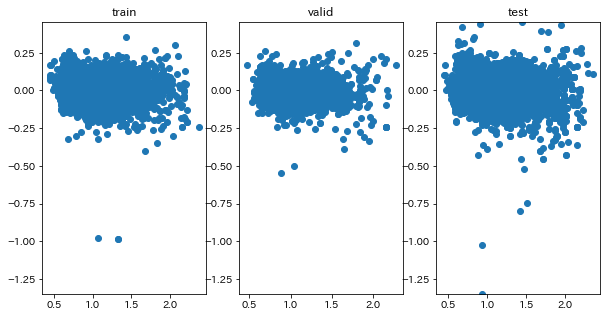

In [821]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

error_train = y_train_pred - y_train
error_valid = y_valid_pred - y_valid
error_test = y_test_pred - y_test

max_ = error_test.max()
min_ = error_test.min()

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, error_train)
ax1.title.set_text('train')
ax1.set_ylim(min_,max_)
ax2.scatter(y_valid_pred, error_valid)
ax2.title.set_text('valid')
ax2.set_ylim(min_,max_)
ax3.scatter(y_test_pred, error_test)
ax3.title.set_text('test')
ax3.set_ylim(min_,max_)

plt.show()

In [822]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[features, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances

,feature,importance
0,最寄駅からの距離,27.853866
1,築年数,730.794777
2,階数,364.718288
3,専有面積,4724.205704
4,市区町村,1246.459905
5,路線,43.295180
6,駅,653.239953
7,間取り_L,3559.449261


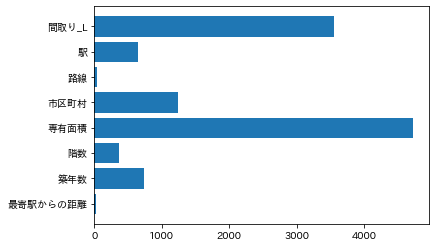

In [823]:
# 変数重要度
# 比率で変わることもないと思うが
plt.barh(table_importances['feature'],table_importances['importance'])
plt.show()

# 残差デカすぎね？ってやつが何なのか調査したい

結論：バカ高い物件って実は他のそこそこの物件と大して差がないんじゃないの？
→賃料が高い物件を見分けるための情報が足りないんじゃないの？

あり得そうな理由
1. オプションがたくさんついている
2. オプションにやべーやつがついている
3. 1部屋がクソ広い
4. 良い向きしとる（たぶんバカ高い理由にはならない）
5. 構造が強い
6. 条件が良質？

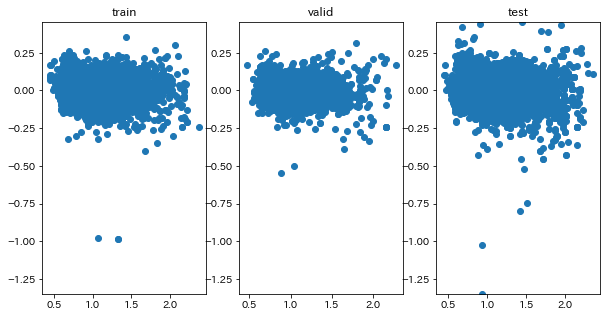

In [912]:
# それぞれの残差プロット
# 変数は8個だけ採用している奴
fig = plt.figure(figsize=(10,5))

error_train = y_train_pred - y_train
error_valid = y_valid_pred - y_valid
error_test = y_test_pred - y_test

max_ = error_test.max()
min_ = error_test.min()

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, error_train)
ax1.title.set_text('train')
ax1.set_ylim(min_,max_)
ax2.scatter(y_valid_pred, error_valid)
ax2.title.set_text('valid')
ax2.set_ylim(min_,max_)
ax3.scatter(y_test_pred, error_test)
ax3.title.set_text('test')
ax3.set_ylim(min_,max_)

plt.show()

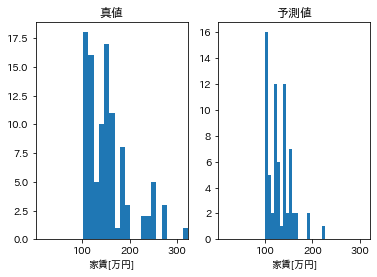

In [915]:
# バカ高い予測が出来なかったって話

max_ = (10**y_test).max()
min_ = (10**y_test).min()

fig, axes = plt.subplots(nrows=1,ncols=2)


condition = 10**y_test > 100
axes[0].hist(10**y_test[condition], bins=20)
axes[0].set_title('真値')
axes[0].set_xlabel('家賃[万円]')
axes[0].set_xlim(min_,max_)

condition = 10**y_test_pred > 100
axes[1].hist(10**y_test_pred[condition], bins=20)
axes[1].set_title('予測値')
axes[1].set_xlabel('家賃[万円]')
axes[1].set_xlim(min_,max_)

plt.savefig('./data/image/cant_predict_high_rent.png')
plt.show()

In [916]:
# テストデータの残差
residual_error = 10**y_test_pred - 10**y_test
X_test['賃料'] = 10**y_test
X_test['予測'] = 10**y_test_pred
X_test['残差'] = residual_error

In [925]:
# 予測がずれまくった皆さんとは？
# condition = X_test['残差'] > 30
# X_test[condition].sort_values('残差')
X_test.sort_values('予測',ascending = False)[:50]

,最寄駅からの距離,築年数,階数,専有面積,市区町村,路線,駅,間取り_L,賃料,予測,残差
147944,0.000000,3,26,142.21,16,24,399,1,175.00,225.811009,50.811009
100393,0.000000,4,25,153.48,16,20,84,1,149.00,193.470406,44.470406
97026,0.000000,11,47,132.48,16,20,84,1,128.00,190.602077,62.602077
60768,1063.447960,15,7,245.59,15,18,69,1,225.00,167.664843,-57.335157
60769,1063.447960,15,7,305.84,15,18,69,1,270.00,167.664843,-102.335157
144036,285.238954,13,6,124.06,15,30,71,1,90.00,159.593368,69.593368
144035,285.238954,13,6,131.74,15,30,71,1,84.00,159.593368,75.593368
144857,821.765470,2,4,181.75,15,7,346,1,240.00,155.703839,-84.296161
41044,0.000000,21,32,186.40,16,20,84,1,150.00,152.700326,2.700326
148589,0.000000,21,34,186.40,16,20,84,1,150.00,152.700326,2.700326


In [929]:
# バカ高い物件がバカ高い理由を探したい
print(suumo.loc[148589,'url'])

https://suumo.jp/chintai/jnc_000076693645/?bc=100296414312


In [ ]:
150万　148589
ガスコンロ対応、
浴室乾燥機、
追焚機能浴室、温水洗浄便座、
脱衣所、
防犯カメラ、ペット相談、照明付、
オートバス、グリル付、CATVインターネット、二人入居相談、
2面バルコニー、
トイレ2ヶ所、
タンクレストイレ、
洗面所にドア、三面鏡付洗面化粧台、シューズWIC、
天井高シューズクロゼット、高速ネット対応、IT重説 対応物件、
全室照明付、

In [ ]:
230万　148592
クロゼット、
洗面化粧台、
閑静な住宅地、
独立型キッチン、24時間有人管理、全居室洋室、振分、
ウォークインクロゼット、バイク置場、全居室フローリング、
ネット使用料不要、トランクルーム、
L字型キッチン、エレベーター2基、
駅徒歩5分以内、制震構造、高層階、
LDK25畳以上、
L字型バルコニー、間接照明、初期費用カード決済可、

In [720]:
# 必要ならデータ加工(未知データに対して実行できないものはやらない)
# シャッフルしてtrainとtestに分ける
# 調整が必要ならtrainをさらにtrainとvalidに分ける
# 必要ならデータ加工
# モデル構築
# モデル学習
# 学習を評価

In [902]:
# 準備フェイズ

# 事前のデータ加工なし
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
#    '皇居からの距離',
#    '歩',
#    'バス',
#    '車',
    '最寄駅からの距離',
    '築年数',
#    '地上',
#    '地下',
    '階数',
#    '階',
#    '部屋数', 
    '専有面積',
]
category_features = [
#    'カテゴリ',
    '市区町村',
    '路線',
    '駅',
#    '間取り',
]
is_features = [
#    '間取り_S', 
    '間取り_L',
#    '間取り_D', 
#    '間取り_K',
]
target_feature = '賃料'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [903]:
# 賃料に対数変換を施す
suumo_light['賃料'] = np.log10(suumo_light['賃料'])

In [904]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]

# 学習用とテスト用に分割
train_test = 0.5
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [905]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    random_state = 0,
    importance_type = 'gain'
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0314019
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0266223
[3]	valid_0's l2: 0.0226955
[4]	valid_0's l2: 0.0194574
[5]	valid_0's l2: 0.0167954
[6]	valid_0's l2: 0.014523
[7]	valid_0's l2: 0.012652
[8]	valid_0's l2: 0.0110867
[9]	valid_0's l2: 0.00975846
[10]	valid_0's l2: 0.00863743
[11]	valid_0's l2: 0.00769819
[12]	valid_0's l2: 0.00693008
[13]	valid_0's l2: 0.00628048
[14]	valid_0's l2: 0.00571282
[15]	valid_0's l2: 0.00523235
[16]	valid_0's l2: 0.00482897
[17]	valid_0's l2: 0.00448839
[18]	valid_0's l2: 0.00418123
[19]	valid_0's l2: 0.00392148
[20]	valid_0's l2: 0.00369556
[21]	valid_0's l2: 0.00350297
[22]	valid_0's l2: 0.00333564
[23]	valid_0's l2: 0.00318725
[24]	valid_0's l2: 0.0030691
[25]	valid_0's l2: 0.00295774
[26]	valid_0's l2: 0.00285808
[27]	valid_0's l2: 0.00276973
[28]	valid_0's l2: 0.00269984
[29]	valid_0's l2: 0.00263257
[30]	valid_0's l2: 0.00257761
[31]	valid_0's l2: 0.00252112
[32]	valid_0's l2: 0.00247544

LGBMRegressor(importance_type='gain', random_state=0)

In [906]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [907]:
# それぞれのr2スコアを算出
# 対数から元に戻そう
print('train:',r2_score(10**y_train,10**y_train_pred))
print('valid:',r2_score(10**y_valid,10**y_valid_pred))
print('test:',r2_score(10**y_test,10**y_test_pred))

train: 0.9065569672632179
valid: 0.8760063131660207
test: 0.8697384399210781


In [908]:
# それぞれのMSEを算出
# 対数から元に戻そう
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 5.673281595056971
valid: 9.774589904928218
test: 9.082280005777013


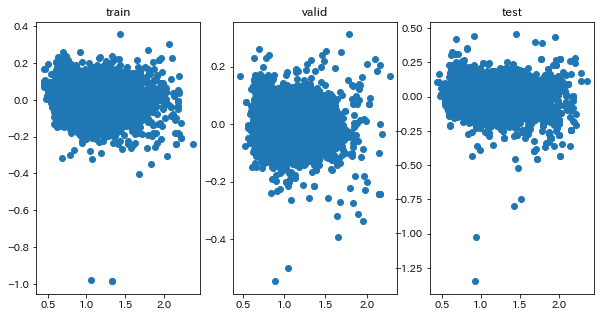

In [909]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, (y_train_pred - y_train))
ax1.title.set_text('train')
ax2.scatter(y_valid_pred, (y_valid_pred - y_valid))
ax2.title.set_text('valid')
ax3.scatter(y_test_pred, (y_test_pred - y_test))
ax3.title.set_text('test')

plt.show()

In [910]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[features, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances

,feature,importance
0,最寄駅からの距離,27.853866
1,築年数,730.794777
2,階数,364.718288
3,専有面積,4724.205704
4,市区町村,1246.459905
5,路線,43.295180
6,駅,653.239953
7,間取り_L,3559.449261


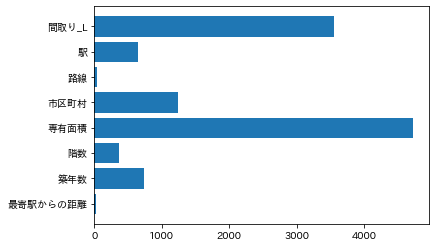

In [911]:
# 変数重要度
# 線形回帰ほどの介護は必要ないらしい
plt.barh(table_importances['feature'],table_importances['importance'])
plt.show()

# パラメータ調整

結論：

In [3]:
# 準備フェイズ
# 10個くらいなくても変わんなくね？という思想。

# 事前のデータ加工なし
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
#    '皇居からの距離',
#    '歩',
#    'バス',
#    '車',
    '最寄駅からの距離',
    '築年数',
#    '地上',
#    '地下',
    '階数',
#    '階',
#    '部屋数', 
    '専有面積',
]
category_features = [
#    'カテゴリ',
    '市区町村',
    '路線',
    '駅',
#    '間取り',
]
is_features = [
#    '間取り_S', 
    '間取り_L',
#    '間取り_D', 
#    '間取り_K',
]
target_feature = '賃料'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [4]:
# 賃料に対数変換を施す
suumo_light['賃料'] = np.log10(suumo_light['賃料'])

In [5]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]

# 学習用とテスト用に分割
# 学習データは半分くらいあればOKっぽい
train_test = 0.5
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [9]:
X_train_before.shape

(78471, 8)

In [8]:
X_test.shape

(78472, 8)

In [4]:
lgb.LGBMRegressor?

In [217]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    random_state = 0,
    importance_type = 'gain',
#    n_estimators = 1000, 重くない？
#    learning_rate = best_learning_rate['learning_rate']
#    max_depth = best_max_depth['max_depth']　70前後。あまり効果なし
#    reg_alpha = best_reg_alpha['reg_alpha']　デフォ(0)でOK
#    reg_lambda = best_reg_lambda['reg_lambda']　デフォ(0)でOK
#    min_child_samples = best_min_child_samples['min_child_samples']  デフォ(20)でOK。ほぼ変化なし
#    subsample = best_subsample['subsample']　何も変わらなかった
#     colsample_bytree = best_colsample_bytree['colsample_bytree'] 0.85～0.9
    num_leaves = best_num_leaves['num_leaves'] 1400
)

# 調整したいパラメータ
def param():
    ret = {
        'colsample_bytree':(0.85,0.86,0.87,0.88,0.89,0.9),
    }
    return ret

# パラメータ調整
gscv = GridSearchCV(LGBM,param(),cv = 5, verbose=2)
gscv.fit(X_train_before,y_train_before)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ..............................colsample_bytree=0.85; total time=   8.9s
[CV] END ..............................colsample_bytree=0.85; total time=  10.0s
[CV] END ..............................colsample_bytree=0.85; total time=   9.0s
[CV] END ..............................colsample_bytree=0.85; total time=   9.4s
[CV] END ..............................colsample_bytree=0.85; total time=   9.6s
[CV] END ..............................colsample_bytree=0.86; total time=   9.6s
[CV] END ..............................colsample_bytree=0.86; total time=   9.1s
[CV] END ..............................colsample_bytree=0.86; total time=   8.9s
[CV] END ..............................colsample_bytree=0.86; total time=   8.5s
[CV] END ..............................colsample_bytree=0.86; total time=   9.9s
[CV] END ..............................colsample_bytree=0.87; total time=   9.3s
[CV] END ..............................colsample_

GridSearchCV(cv=5,
             estimator=LGBMRegressor(importance_type='gain', num_leaves=1400,
                                     random_state=0),
             param_grid={'colsample_bytree': (0.85, 0.86, 0.87, 0.88, 0.89,
                                              0.9)},
             verbose=2)

In [218]:
gscv.cv_results_['mean_test_score']

array([0.96036539, 0.96036539, 0.96036539, 0.96036539, 0.96036539,
       0.96036539])

{'colsample_bytree': 0.85}
0.960365388048408


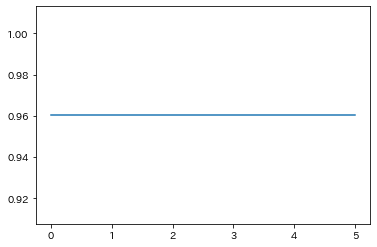

In [219]:
# colsample_bytreeは0.85～0.9
param = 'colsample_bytree'
exec(f"best_{param} = gscv.best_params_")
exec(f"score_{param} = gscv.best_score_")
exec(f"print(best_{param})")
exec(f"print(score_{param})")
plt.plot(gscv.cv_results_['mean_test_score'])
plt.show()

{'colsample_bytree': 0.85}
0.960365388048408


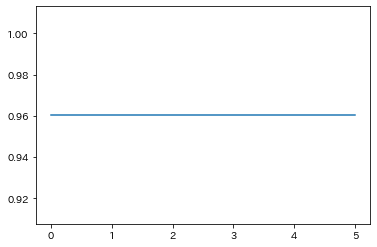

In [219]:
# colsample_bytreeは0.85～0.9
param = 'colsample_bytree'
exec(f"best_{param} = gscv.best_params_")
exec(f"score_{param} = gscv.best_score_")
exec(f"print(best_{param})")
exec(f"print(score_{param})")
plt.plot(gscv.cv_results_['mean_test_score'])
plt.show()

{'subsample': 0.2}
0.9596591872597042


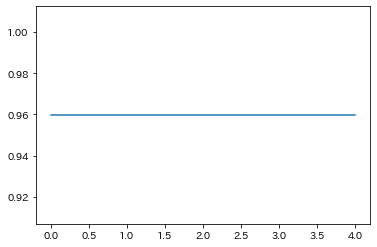

In [205]:
# subsampleは無意味
param = 'min_chils_samples'
exec(f"best_{param} = gscv.best_params_")
exec(f"score_{param} = gscv.best_score_")
exec(f"print(best_{param})")
exec(f"print(score_{param})")
plt.plot(gscv.cv_results_['mean_test_score'])
plt.show()

{'min_child_samples': 20}
0.9596591872597042


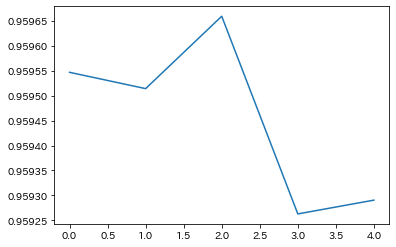

In [200]:
# min_chils_samplesは20でOK
param = 'min_chils_samples'
exec(f"best_{param} = gscv.best_params_")
exec(f"score_{param} = gscv.best_score_")
exec(f"print(best_{param})")
exec(f"print(score_{param})")
plt.plot(gscv.cv_results_['mean_test_score'])
plt.show()

{'reg_lambda': 1}
0.9597746044795986


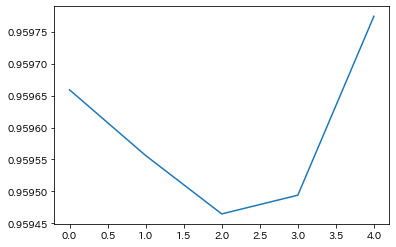

In [189]:
# reg_lambdaは0でOK。調整不要
param = 'reg_lambda'
exec(f"best_{param} = gscv.best_params_")
exec(f"score_{param} = gscv.best_score_")
exec(f"print(best_{param})")
exec(f"print(score_{param})")
plt.plot(gscv.cv_results_['mean_test_score'])
plt.show()

{'reg_alpha': 0}
0.9596591872597042


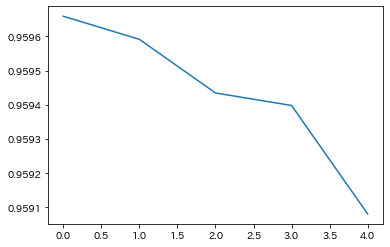

In [181]:
# reg_alphaは0でOK。調整不要
param = 'reg_alpha'
exec(f"best_{param} = gscv.best_params_")
exec(f"score_{param} = gscv.best_score_")
exec(f"print(best_{param})")
exec(f"print(score_{param})")
plt.plot(gscv.cv_results_['mean_test_score'])
plt.show()

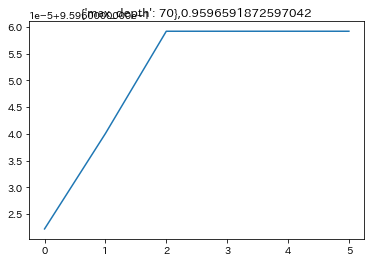

In [156]:
# max_depthはあってもなくても変わらん
# 入れるなら70前後
best_max_depth = gscv.best_params_
score_max_depth = gscv.best_score_
plt.plot(gscv.cv_results_['mean_test_score'])
plt.title(f'{best_max_depth},{score_max_depth}')
plt.show()

{'num_leaves': 1400}
0.9596591872597042


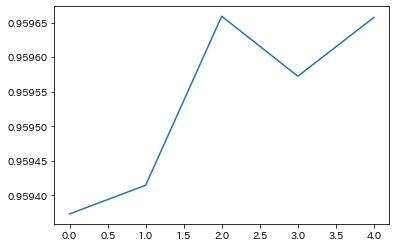

In [140]:
# num_leavesは1400あたり
param = 'num_leaves'
exec(f"best_{param} = gscv.best_params_")
exec(f"score_{param} = gscv.best_score_")
exec(f"print(best_{param})")
exec(f"print(score_{param})")
plt.plot(gscv.cv_results_['mean_test_score'])
plt.show()

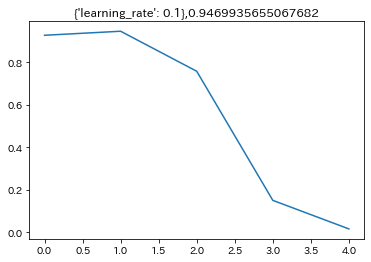

In [35]:
# learning_rateは0～0.1
best_learning_rate = gscv.best_params_
score_learning_rate = gscv.best_score_
plt.plot(gscv.cv_results_['mean_test_score'])
plt.title(f'{best_learning_rate},{score_learning_rate}')
plt.show()

In [31]:
lgb.LGBMRegressor?

In [170]:
# 準備フェイズ

# 事前のデータ加工なし
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
#    '皇居からの距離',
#    '歩',
#    'バス',
#    '車',
    '最寄駅からの距離',
    '築年数',
#    '地上',
#    '地下',
    '階数',
#    '階',
#    '部屋数', 
    '専有面積',
]
category_features = [
#    'カテゴリ',
    '市区町村',
    '路線',
    '駅',
#    '間取り',
]
is_features = [
#    '間取り_S', 
    '間取り_L',
#    '間取り_D', 
#    '間取り_K',
]
target_feature = '賃料'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [171]:
# 賃料に対数変換を施す
suumo_light['賃料'] = np.log10(suumo_light['賃料'])

In [172]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]

# 学習用とテスト用に分割
train_test = 0.5
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [220]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    random_state = 0,
    importance_type = 'gain',
    n_estimators = 1000,
    learning_rate = best_learning_rate['learning_rate'],
    num_leaves = best_num_leaves['num_leaves'],
    max_depth = best_max_depth['max_depth'],
    colsample_bytree = best_colsample_bytree['colsample_bytree']
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0307687
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0254956
[3]	valid_0's l2: 0.0211971
[4]	valid_0's l2: 0.0176937
[5]	valid_0's l2: 0.0148294
[6]	valid_0's l2: 0.0125228
[7]	valid_0's l2: 0.0106252
[8]	valid_0's l2: 0.00906257
[9]	valid_0's l2: 0.00778386
[10]	valid_0's l2: 0.00674123
[11]	valid_0's l2: 0.00588206
[12]	valid_0's l2: 0.0051755
[13]	valid_0's l2: 0.00460411
[14]	valid_0's l2: 0.00418026
[15]	valid_0's l2: 0.00383231
[16]	valid_0's l2: 0.0034916
[17]	valid_0's l2: 0.00325404
[18]	valid_0's l2: 0.0030009
[19]	valid_0's l2: 0.00283784
[20]	valid_0's l2: 0.00269906
[21]	valid_0's l2: 0.00258544
[22]	valid_0's l2: 0.00243966
[23]	valid_0's l2: 0.00232176
[24]	valid_0's l2: 0.00222838
[25]	valid_0's l2: 0.00214438
[26]	valid_0's l2: 0.00209368
[27]	valid_0's l2: 0.00203109
[28]	valid_0's l2: 0.00197631
[29]	valid_0's l2: 0.00192645
[30]	valid_0's l2: 0.00188596
[31]	valid_0's l2: 0.00185217
[32]	valid_0's l2: 0.0018275

LGBMRegressor(colsample_bytree=0.85, importance_type='gain', max_depth=70,
              n_estimators=1000, num_leaves=1400, random_state=0)

In [221]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [222]:
# それぞれのr2スコアを算出
# 対数から元に戻そう
# パラメータ調整前が0.869。そこそこ向上した
print('train:',r2_score(10**y_train,10**y_train_pred))
print('valid:',r2_score(10**y_valid,10**y_valid_pred))
print('test:',r2_score(10**y_test,10**y_test_pred))

train: 0.9818864392722341
valid: 0.919564465154598
test: 0.9020978266248817


In [223]:
# それぞれのMSEを算出
# 対数から元に戻そう
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 1.0997431021663562
valid: 6.340841916815332
test: 6.826073257745609


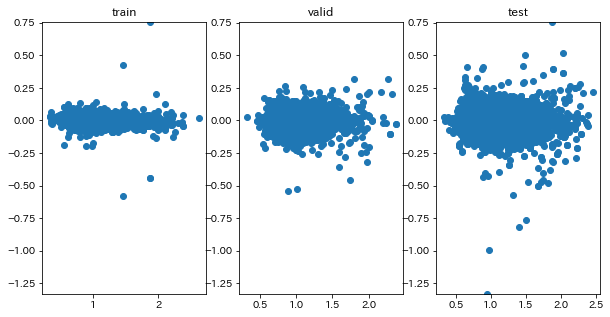

In [227]:
# それぞれの残差プロット
# 調整したところで無理な奴は無理なんだよね。
fig = plt.figure(figsize=(10,5))

error_train = y_train_pred - y_train
error_valid = y_valid_pred - y_valid
error_test = y_test_pred - y_test

max_ = error_test.max()
min_ = error_test.min()

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, error_train)
ax1.title.set_text('train')
ax1.set_ylim(min_,max_)
ax2.scatter(y_valid_pred, error_valid)
ax2.title.set_text('valid')
ax2.set_ylim(min_,max_)
ax3.scatter(y_test_pred, error_test)
ax3.title.set_text('test')
ax3.set_ylim(min_,max_)

plt.show()

In [228]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[features, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances

,feature,importance
0,最寄駅からの距離,251.185243
1,築年数,889.843718
2,階数,345.877229
3,専有面積,6174.560512
4,市区町村,1332.356977
5,路線,81.698798
6,駅,502.853658
7,間取り_L,2183.055196


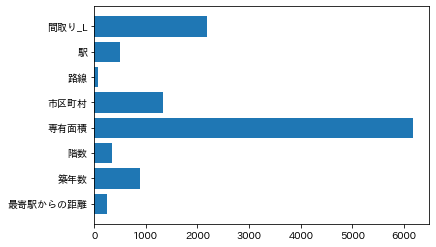

In [229]:
# 変数重要度
plt.barh(table_importances['feature'],table_importances['importance'])
plt.show()

# アプリに入れるモデル

In [4]:
# 準備フェイズ

# 事前のデータ加工なし
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
#    '皇居からの距離',
#    '歩',
#    'バス',
#    '車',
    '最寄駅からの距離',
    '築年数',
#    '地上',
#    '地下',
    '階数',
#    '階',
#    '部屋数', 
    '専有面積',
]
category_features = [
    'カテゴリ',
    '市区町村',
    '路線',
    '駅',
    '間取り',
]
is_features = [
#    '間取り_S', 
#    '間取り_L',
#    '間取り_D', 
#    '間取り_K',
]
target_feature = '賃料'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [139]:
condition = suumo['間取り'] == "2LDK"
suumo.loc[condition,'専有面積'].tolist()

[52.04,
 57.57,
 61.75,
 62.23,
 61.4,
 69.09,
 50.87,
 59.09,
 55.08,
 55.08,
 55.08,
 58.62,
 55.08,
 64.9,
 65.61,
 55.03,
 55.05,
 41.88,
 41.88,
 62.41,
 64.28,
 62.41,
 62.41,
 55.15,
 45.65,
 51.53,
 58.31,
 53.1,
 45.37,
 45.37,
 40.92,
 40.92,
 40.92,
 40.92,
 40.92,
 40.92,
 40.92,
 58.28,
 58.94,
 69.58,
 56.87,
 72.09,
 69.58,
 73.79,
 42.89,
 50.6,
 50.6,
 61.66,
 61.66,
 60.77,
 57.87,
 57.87,
 57.87,
 57.87,
 57.87,
 57.87,
 54.85,
 50.97,
 50.97,
 50.97,
 50.97,
 60.86,
 60.86,
 59.24,
 59.24,
 59.23,
 61.57,
 60.46,
 70.78,
 87.66,
 92.48,
 80.23,
 86.67,
 86.67,
 56.4,
 50.92,
 55.1,
 55.1,
 55.46,
 55.46,
 50.82,
 50.82,
 54.88,
 54.88,
 50.82,
 50.82,
 50.82,
 50.82,
 81.28,
 85.7,
 85.7,
 60.6,
 48.49,
 48.49,
 57.85,
 55.68,
 55.68,
 60.86,
 54.0,
 59.22,
 59.22,
 50.4,
 56.55,
 50.53,
 50.53,
 61.19,
 55.36,
 55.89,
 41.19,
 41.19,
 41.19,
 41.19,
 41.19,
 41.19,
 41.19,
 51.1,
 51.1,
 51.1,
 51.74,
 51.74,
 40.08,
 40.08,
 40.08,
 40.08,
 40.08,
 40.08,
 51.69,


In [142]:
table_カテゴリ.to_csv('./data/csv/table_category.csv', index=False)
table_市区町村.to_csv('./data/csv/table_ward.csv', index=False)
table_路線.to_csv('./data/csv/table_line.csv', index=False)
table_駅.to_csv('./data/csv/table_station.csv', index=False)
table_間取り.to_csv('./data/csv/table_floor_plan.csv', index=False)

In [225]:
table_category = pd.read_csv('./data/csv/table_category.csv')
table_ward = pd.read_csv('./data/csv/table_ward.csv')
table_line = pd.read_csv('./data/csv/table_line.csv')
table_station = pd.read_csv('./data/csv/table_station.csv')
table_floor_plan= pd.read_csv('./data/csv/table_floor_plan.csv')

In [163]:
for index, row in table_category.iterrows():
    print(row['num'])

0
1
2
3
4


In [9]:
# 賃料に対数変換を施す
suumo_light['賃料'] = np.log10(suumo_light['賃料'])

In [11]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]

# 学習用とテスト用に分割
train_test = 0.5
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [10]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    random_state = 0,
    importance_type = 'gain',
    n_estimators = 1000,
    learning_rate = 0.1,
    num_leaves = 1400,
    max_depth = 70,
    colsample_bytree = 0.85,
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0307687
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0254956
[3]	valid_0's l2: 0.0211971
[4]	valid_0's l2: 0.0176937
[5]	valid_0's l2: 0.0148294
[6]	valid_0's l2: 0.0125228
[7]	valid_0's l2: 0.0106252
[8]	valid_0's l2: 0.00906257
[9]	valid_0's l2: 0.00778386
[10]	valid_0's l2: 0.00674123
[11]	valid_0's l2: 0.00588206
[12]	valid_0's l2: 0.0051755
[13]	valid_0's l2: 0.00460411
[14]	valid_0's l2: 0.00418026
[15]	valid_0's l2: 0.00383231
[16]	valid_0's l2: 0.0034916
[17]	valid_0's l2: 0.00325404
[18]	valid_0's l2: 0.0030009
[19]	valid_0's l2: 0.00283784
[20]	valid_0's l2: 0.00269906
[21]	valid_0's l2: 0.00258544
[22]	valid_0's l2: 0.00243966
[23]	valid_0's l2: 0.00232176
[24]	valid_0's l2: 0.00222838
[25]	valid_0's l2: 0.00214438
[26]	valid_0's l2: 0.00209368
[27]	valid_0's l2: 0.00203109
[28]	valid_0's l2: 0.00197631
[29]	valid_0's l2: 0.00192645
[30]	valid_0's l2: 0.00188596
[31]	valid_0's l2: 0.00185217
[32]	valid_0's l2: 0.0018275

LGBMRegressor(colsample_bytree=0.85, importance_type='gain', max_depth=70,
              n_estimators=1000, num_leaves=1400, random_state=0)

In [11]:
LGBM

LGBMRegressor(colsample_bytree=0.85, importance_type='gain', max_depth=70,
              n_estimators=1000, num_leaves=1400, random_state=0)

In [24]:
# pickleにモデルを保存
import pickle

file = "trained_LGBM.pkl"
pickle.dump(LGBM,open(file, 'wb'))

In [30]:
clf = pickle.load(open("trained_LGBM.pkl", 'rb'))
clf

LGBMRegressor(colsample_bytree=0.85, importance_type='gain', max_depth=70,
              n_estimators=1000, num_leaves=1400, random_state=0)

In [12]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [13]:
# それぞれのr2スコアを算出
# 対数から元に戻そう
# パラメータ調整前が0.869。そこそこ向上した
print('train:',r2_score(10**y_train,10**y_train_pred))
print('valid:',r2_score(10**y_valid,10**y_valid_pred))
print('test:',r2_score(10**y_test,10**y_test_pred))

train: 0.9818864392722341
valid: 0.919564465154598
test: 0.9020978266248817


In [18]:
# それぞれのr2スコアを算出
# 対数から元に戻そう
# パラメータ調整前が0.869。そこそこ向上した
print('train:',r2_score(y_train,y_train_pred))
print('valid:',r2_score(y_valid,y_valid_pred))
print('test:',r2_score(y_test,y_test_pred))

train: 0.9956921673484771
valid: 0.9618431712852027
test: 0.9615086647046235


In [24]:
# それぞれのMSEを算出
# 対数から元に戻そう
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 1.0997431021663562
valid: 6.340841916815332
test: 6.826073257745609


In [25]:
mean_squared_error?

In [19]:
# それぞれのMSEを算出
# 対数から元に戻そう
print('train:',mean_squared_error(y_train,y_train_pred))
print('valid:',mean_squared_error(y_valid,y_valid_pred))
print('test:',mean_squared_error(y_test,y_test_pred))

train: 0.00015516953719557457
valid: 0.00142205719261501
test: 0.0014066193448475802


In [15]:
# それぞれの予測結果を収納(clf)
y_train_pred = clf.predict(X_train)
y_valid_pred = clf.predict(X_valid)
y_test_pred = clf.predict(X_test)

NameError: name 'clf' is not defined

In [ ]:
# それぞれのr2スコアを算出
# 対数から元に戻そう
# パラメータ調整前が0.869。そこそこ向上した
print('train:',r2_score(10**y_train,10**y_train_pred))
print('valid:',r2_score(10**y_valid,10**y_valid_pred))
print('test:',r2_score(10**y_test,10**y_test_pred))

In [ ]:
# それぞれのMSEを算出
# 対数から元に戻そう
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

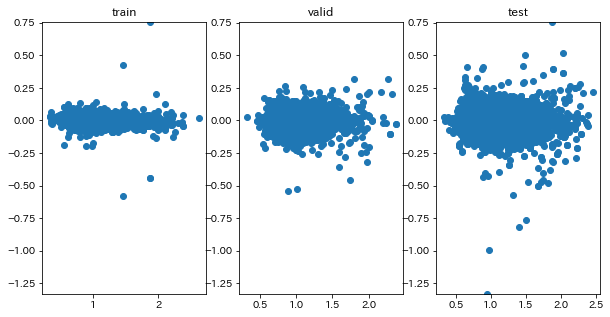

In [16]:
# それぞれの残差プロット
# 調整したところで無理な奴は無理なんだよね。
fig = plt.figure(figsize=(10,5))

error_train = y_train_pred - y_train
error_valid = y_valid_pred - y_valid
error_test = y_test_pred - y_test

max_ = error_test.max()
min_ = error_test.min()

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, error_train)
ax1.title.set_text('train')
ax1.set_ylim(min_,max_)
ax2.scatter(y_valid_pred, error_valid)
ax2.title.set_text('valid')
ax2.set_ylim(min_,max_)
ax3.scatter(y_test_pred, error_test)
ax3.title.set_text('test')
ax3.set_ylim(min_,max_)

plt.show()

In [17]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[features, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances

,feature,importance
0,最寄駅からの距離,251.185243
1,築年数,889.843718
2,階数,345.877229
3,専有面積,6174.560512
4,市区町村,1332.356977
5,路線,81.698798
6,駅,502.853658
7,間取り_L,2183.055196


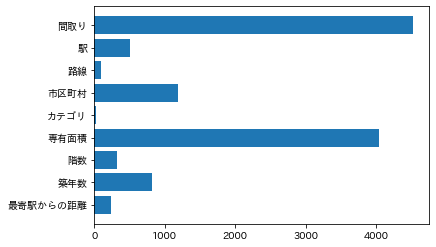

In [20]:
# 変数重要度
plt.barh(table_importances['feature'],table_importances['importance'])
plt.show()

# あとやれそうなことは？

In [642]:
# 外れ値は入れといていいはず
# 入力ミスは弾いて良いと思う
# 残差デカすぎ奴の調査
# 次元削減とのコンボ
# オプションを追加しよう

In [233]:
# optuna を使いたい場合はこちら
# 重すぎてつらい。

kf = KFold(n_splits=5)
def objective(trial):
    n_estimators = 1000
    num_leaves = trial.suggest_int('num_leaves',1300,1500)
    learning_rate = trial.suggest_float('learning_rate',0.01,1)
    colsample_bytree = trial.suggest_float('colsample_bytree',0.85,0.9)
    
    LGBM = lgb.LGBMRegressor(
        n_estimators = n_estimators,
        importance_type = 'gain',
        num_leaves = num_leaves,
        learning_rate = learning_rate,
        colsample_bytree = colsample_bytree,
        random_state = 0
    )
    
    result = cross_validate(
        estimator = LGBM,
        X = X_train_before,
        y = y_train_before,
        cv = kf,
        scoring = 'neg_mean_squared_error'
    )
    
    val_rmse = result['test_score'].mean()
    
    return val_rmse

In [234]:
# optuna を実行
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-11-04 14:01:09,625] A new study created in memory with name: no-name-776ab4d8-b362-4283-8f92-6cf80d2007b7
[I 2022-11-04 14:08:17,455] Trial 0 finished with value: -0.0013870545414727202 and parameters: {'num_leaves': 1314, 'learning_rate': 0.035775360240646106, 'colsample_bytree': 0.8595981109162605}. Best is trial 0 with value: -0.0013870545414727202.
[I 2022-11-04 14:16:56,040] Trial 1 finished with value: -0.0018004509378400546 and parameters: {'num_leaves': 1420, 'learning_rate': 0.5771310009424033, 'colsample_bytree': 0.8685622995532537}. Best is trial 0 with value: -0.0013870545414727202.
[I 2022-11-04 14:25:57,403] Trial 2 finished with value: -0.0022899342101175774 and parameters: {'num_leaves': 1447, 'learning_rate': 0.9106959298359614, 'colsample_bytree': 0.8946608814923894}. Best is trial 0 with value: -0.0013870545414727202.
[I 2022-11-04 14:35:29,497] Trial 3 finished with value: -0.0015590671150852488 and parameters: {'num_leaves': 1474, 'learning_rate': 0.3174475

KeyboardInterrupt: 